In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Proj
import cartopy.feature as cfeature
from pathlib import Path
from matplotlib.colors import BoundaryNorm 
import glob
import cmaqsatproc as csp
from sklearn.metrics import mean_squared_error

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scienceplots 
# Check if 'science' style is available
if 'science' in plt.style.available:
	plt.style.use(['science', 'no-latex'])
	matplotlib.rcParams['font.family'] = 'DejaVu Sans'
else:
	print("'science' style is not available. Try restarting the kernel after installing SciencePlots.")

In [3]:
# Define the file paths for BASE and ASSIM runs
base_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_BASE/*/AQS_Daily_O3_EMBER_BASE.csv')
base_files = [f for f in base_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
assim_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_ASSIM/*/AQS_Daily_O3_EMBER_ASSIM.csv')
assim_files = [f for f in assim_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
scale_assim_files = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_SCALE_ASSIM_FINAL_202506/*/AQS_Daily_O3_EMBER_SCALE_ASSIM_FINAL_202506.csv')

In [4]:
# Define the file paths for BASE and ASSIM runs
base_files2 = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_BASE/*/AQS_Daily_EMBER_BASE.csv')
base_files2 = [f for f in base_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
assim_files2 = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_ASSIM/*/AQS_Daily_EMBER_ASSIM.csv')
assim_files2 = [f for f in assim_files if any(month in f for month in ['202305', '202306', '202307', '202308', '202309'])]
scale_assim_files2 = glob.glob('/work/MOD3DEV/jkumm/EMBER/CMAQ/36US3/eval/POST/EMBER_SCALE_ASSIM_FINAL_202506/*/AQS_Daily_EMBER_SCALE_ASSIM_FINAL_202506.csv')

In [5]:
def calculate_metrics(obs, mod):
    correlation = obs.corr(mod)
    rmse = np.sqrt(mean_squared_error(obs, mod))
    nme = 100 * (np.abs(mod - obs).sum() / obs.sum())
    nmb = 100 * ((mod - obs).sum() / obs.sum())
    return correlation, rmse, nme, nmb

In [6]:
# Initialize lists to store monthly statistics
monthly_stats_base = []
monthly_stats_assim = []
monthly_stats_scale_assim = []

# Loop through each month's files
for base_file, assim_file, scale_assim_file in zip(base_files, assim_files, scale_assim_files):

    # Read the data
    bdf = pd.read_csv(base_file, skiprows=5, na_values=[-999])
    adf = pd.read_csv(assim_file, skiprows=5, na_values=[-999])
    cdf = pd.read_csv(scale_assim_file, skiprows=5, na_values=[-999])
    
    # Rename 'O3_8hrmax_9cell_mod' column in cdf to 'O3_8hrmax_9cell_mod_scale_assim' for clarity
    cdf = cdf.rename(columns={'O3_8hrmax_9cell_mod': 'O3_8hrmax_9cell_mod_scale_assim'})
    
    # Reset indices to ensure alignment
    bdf = bdf.reset_index()
    adf = adf.reset_index()
    cdf = cdf.reset_index()

    # cdf = cdf.rename(columns={'O3_8hrmax_9cell_mod': 'O3_8hrmax_9cell_mod_scale_assim'})

    # Drop rows with NaN values in the relevant columns
    valid_data = bdf[['O3_8hrmax_9cell_ob', 'O3_8hrmax_9cell_mod']].join(adf[['O3_8hrmax_9cell_mod']], lsuffix='_base', rsuffix='_assim').dropna()

    valid_data = valid_data.join(cdf[['O3_8hrmax_9cell_mod_scale_assim']]).dropna()

    # Debug: Print intermediate data
    print(valid_data.head())

    # Observed and modeled O3_8hrmax_9cell for BASE and ASSIM
    obs_O3_8hrmax_9cell = valid_data['O3_8hrmax_9cell_ob']
    base_O3_8hrmax_9cell = valid_data['O3_8hrmax_9cell_mod_base']
    assim_O3_8hrmax_9cell = valid_data['O3_8hrmax_9cell_mod_assim']
    scale_assim_O3_8hrmax_9cell = valid_data['O3_8hrmax_9cell_mod_scale_assim']
    
    # Calculate metrics for BASE and ASSIM
    base_metrics = calculate_metrics(obs_O3_8hrmax_9cell, base_O3_8hrmax_9cell)
    assim_metrics = calculate_metrics(obs_O3_8hrmax_9cell, assim_O3_8hrmax_9cell)
    scale_assim_metrics = calculate_metrics(obs_O3_8hrmax_9cell, scale_assim_O3_8hrmax_9cell)

    # Append to the monthly statistics lists
    monthly_stats_base.append(base_metrics)
    monthly_stats_assim.append(assim_metrics)
    monthly_stats_scale_assim.append(scale_assim_metrics)




   O3_8hrmax_9cell_ob  O3_8hrmax_9cell_mod_base  O3_8hrmax_9cell_mod_assim  \
0              37.875                    39.262                     39.057   
1              28.875                    38.520                     38.636   
2              33.875                    41.859                     41.764   
3              33.250                    38.585                     38.972   
4              35.250                    40.855                     40.836   

   O3_8hrmax_9cell_mod_scale_assim  
0                           37.888  
1                           38.469  
2                           40.554  
3                           38.558  
4                           41.710  
   O3_8hrmax_9cell_ob  O3_8hrmax_9cell_mod_base  O3_8hrmax_9cell_mod_assim  \
0              56.875                    65.770                     65.805   
1              62.143                    62.954                     63.454   
2              67.500                    63.354                     63.903 

In [7]:
# Read and concatenate all months for each run
BDF = pd.concat([pd.read_csv(f, skiprows=5, na_values=[-999]) for f in base_files], ignore_index=True)
ADF = pd.concat([pd.read_csv(f, skiprows=5, na_values=[-999]) for f in assim_files], ignore_index=True)
CDF = pd.concat([pd.read_csv(f, skiprows=5, na_values=[-999]) for f in scale_assim_files], ignore_index=True)
# Rename for clarity
CDF = CDF.rename(columns={'O3_8hrmax_9cell_mod': 'O3_8hrmax_9cell_mod_scale_assim'})
ADF = ADF.rename(columns={'O3_8hrmax_9cell_mod': 'O3_8hrmax_9cell_mod_assim'})

In [8]:
# Convert lists to DataFrames for easier averaging
monthly_stats_base_df = pd.DataFrame(monthly_stats_base, columns=['Correlation', 'RMSE', 'NME', 'NMB'])
monthly_stats_assim_df = pd.DataFrame(monthly_stats_assim, columns=['Correlation', 'RMSE', 'NME', 'NMB'])
monthly_stats_scale_assim_df = pd.DataFrame(monthly_stats_scale_assim, columns=['Correlation', 'RMSE', 'NME', 'NMB'])

# Calculate overall averages
overall_base_stats = monthly_stats_base_df.mean()
overall_assim_stats = monthly_stats_assim_df.mean()
overall_scale_assim_stats = monthly_stats_scale_assim_df.mean()

# Print overall statistics
print("Overall BASE Metrics:")
print(overall_base_stats)
print("\nOverall ASSIM Metrics:")
print(overall_assim_stats)
print("\nOverall SCALE ASSIM Metrics:")
print(overall_scale_assim_stats)

Overall BASE Metrics:
Correlation     0.627306
RMSE           11.756918
NME            19.765406
NMB            14.318566
dtype: float64

Overall ASSIM Metrics:
Correlation     0.635820
RMSE           11.723959
NME            19.724213
NMB            14.624673
dtype: float64

Overall SCALE ASSIM Metrics:
Correlation     0.654339
RMSE           11.107437
NME            18.472831
NMB            13.089609
dtype: float64


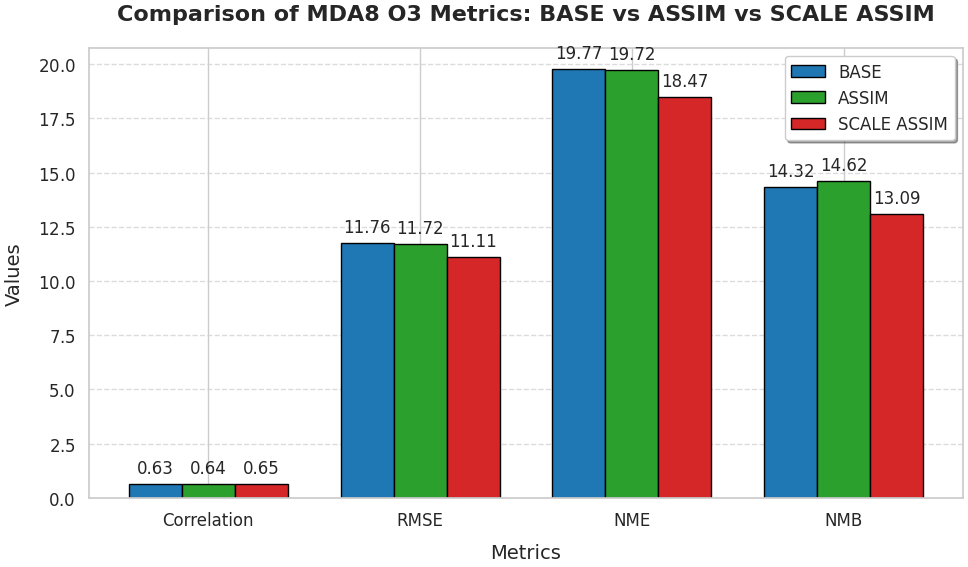

In [9]:
# Enhanced bar chart for metrics
import seaborn as sns

# Use a publication-friendly style
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.size": 14,  # Increase font size
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (12, 8)  # Larger figure size
})

metrics = ['Correlation', 'RMSE', 'NME', 'NMB']
base_values = overall_base_stats.values
assim_values = overall_assim_stats.values
scale_assim_values = overall_scale_assim_stats.values

x = np.arange(len(metrics))  # Label locations
width = 0.25  # Adjusted bar width for better spacing

fig, ax = plt.subplots(figsize=(10, 6))

# Use more distinct colors for better contrast
bars1 = ax.bar(x - width, base_values, width, label='BASE', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x, assim_values, width, label='ASSIM', color='#2ca02c', edgecolor='black')
bars3 = ax.bar(x + width, scale_assim_values, width, label='SCALE ASSIM', color='#d62728', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Metrics', labelpad=10)
ax.set_ylabel('Values', labelpad=10)
ax.set_title('Comparison of MDA8 O3 Metrics: BASE vs ASSIM vs SCALE ASSIM', pad=20, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(loc='best', frameon=True, shadow=True, fancybox=True)

# Annotate bar values
for bars in [bars1, bars2, bars3]:
    ax.bar_label(bars, fmt='%.2f', padding=5, fontsize=12)

# Add gridlines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure as a high-resolution image for publication
plt.savefig('MDA8_O3_Metrics_Comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

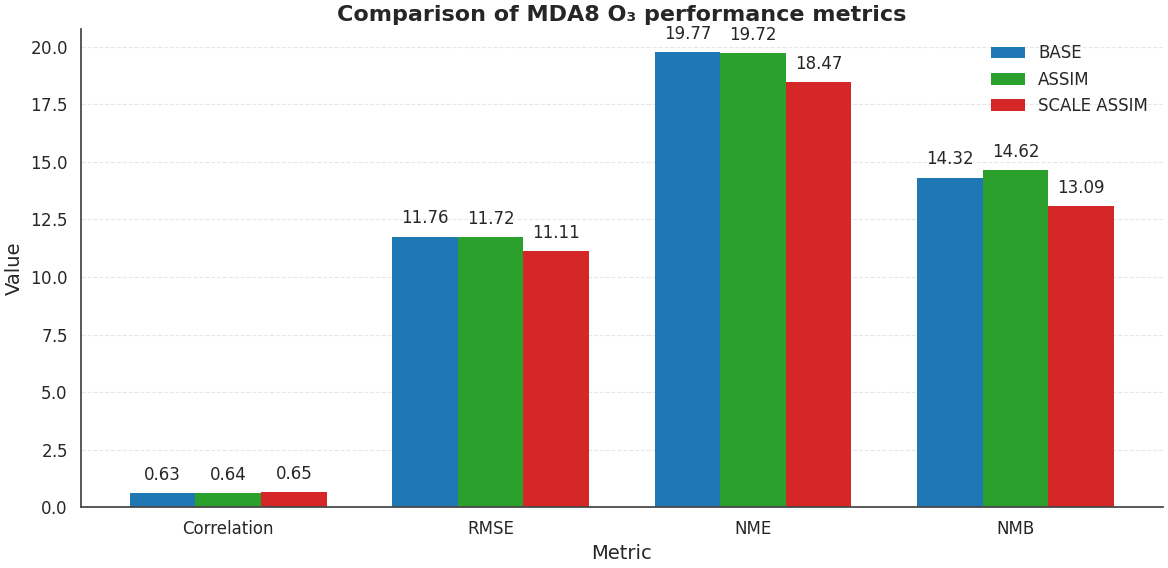

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, AutoMinorLocator
import seaborn as sns

# --- Publication‐ready settings ---
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Helvetica'],
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': '#444444',
    'grid.color':    '#DDDDDD',
    'grid.linestyle':'--',
    'grid.linewidth':0.8,
    'axes.grid':     False,        # we'll turn on only y‐grid
    'figure.figsize':(12, 6),
})

# --- Data (example) ---
metrics             = ['Correlation', 'RMSE', 'NME', 'NMB']
base_values         = overall_base_stats.values
assim_values        = overall_assim_stats.values
scale_assim_values  = overall_scale_assim_stats.values

x     = np.arange(len(metrics))
width = 0.25

# --- Create figure & axis ---
fig, ax = plt.subplots()

# --- Bars ---
bars_base = ax.bar(
    x - width, base_values, width,
    label='BASE', color='#1f77b4', edgecolor='none'
)
bars_assim = ax.bar(
    x, assim_values, width,
    label='ASSIM', color='#2ca02c', edgecolor='none'
)
bars_scale = ax.bar(
    x + width, scale_assim_values, width,
    label='SCALE ASSIM', color='#d62728', edgecolor='none'
)

# --- Axis formatting ---
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Comparison of MDA8 O₃ performance metrics')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(axis='y', which='major', alpha=0.7)

# Hide top/right spines
for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

# --- Annotate bars with exact values ---
for bar_group in (bars_base, bars_assim, bars_scale):
    for bar in bar_group:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + 0.02 * max(base_values.max(), scale_assim_values.max()),
            f"{h:.2f}", ha='center', va='bottom', fontsize=12
        )

# --- Legend above plot ---
ax.legend(
    loc='upper right',
    # bbox_to_anchor=(0.5, 0.95),
    ncol=1,
    fontsize = 12,
    frameon=False
)

plt.tight_layout()
plt.savefig('MDA8_O3_Metrics_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

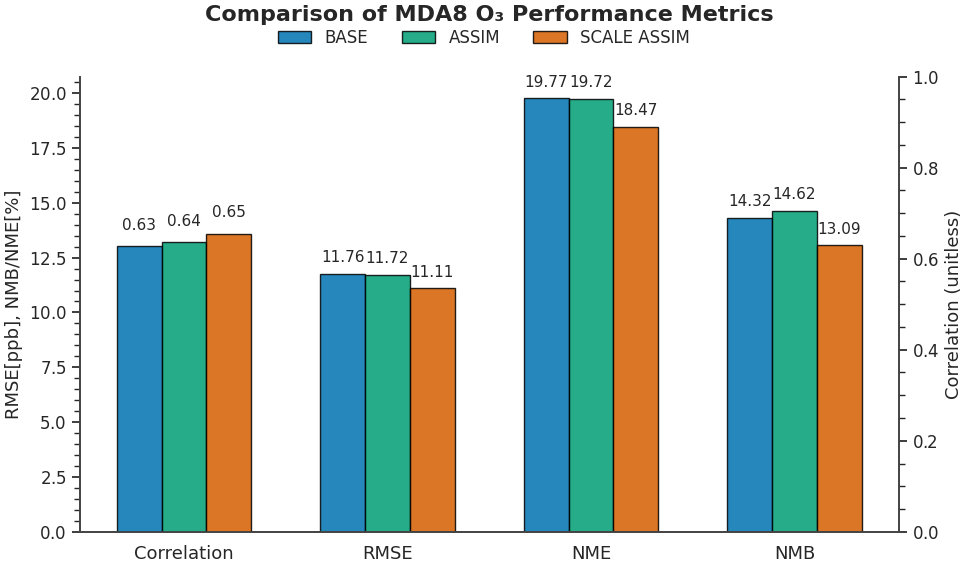

In [11]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Correlation', 'RMSE', 'NME', 'NMB']
base_values = overall_base_stats.values
assim_values = overall_assim_stats.values
scale_assim_values = overall_scale_assim_stats.values

x = np.arange(len(metrics))
width = 0.22

# Colorblind-friendly, deeper hues
colors = {
    'BASE':    '#0072B2',  # blue
    'ASSIM':   '#009E73',  # green
    'SCALE ASSIM':   '#D55E00',  # red
}

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSE, NME, NMB on left y-axis
for idx, (vals, label, color) in enumerate([
    (base_values, 'BASE', colors['BASE']),
    (assim_values, 'ASSIM', colors['ASSIM']),
    (scale_assim_values, 'SCALE ASSIM', colors['SCALE ASSIM']),
]):
    # Only plot RMSE, NME, NMB (skip Correlation)
    bars = ax1.bar(
        x[1:] + (idx-1)*width, vals[1:], width,
        label=label, color=color, edgecolor='black', alpha=0.85
    )
    # Annotate
    for i, bar in enumerate(bars):
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + 0.02*max(vals[1:]), f"{h:.2f}",
                 ha='center', va='bottom', fontsize=11)

ax1.set_ylabel('RMSE[ppb], NMB/NME[%]', fontsize=13)
ax1.set_xticks(x[1:])
ax1.set_xticklabels(metrics[1:], fontsize=13)
ax1.tick_params(axis='y', labelsize=12)

# Twin y-axis for Correlation
ax2 = ax1.twinx()
for idx, (vals, label, color) in enumerate([
    (base_values, 'BASE', colors['BASE']),
    (assim_values, 'ASSIM', colors['ASSIM']),
    (scale_assim_values, 'SCALE ASSIM', colors['SCALE ASSIM']),
]):
    bar = ax2.bar(
        x[0] + (idx-1)*width, vals[0], width,
        label=label if idx==0 else "", color=color, edgecolor='black', alpha=0.85
    )
    # Annotate
    h = vals[0]
    ax2.text(bar[0].get_x() + bar[0].get_width()/2, h + 0.03, f"{h:.2f}",
             ha='center', va='bottom', fontsize=11)

ax2.set_ylim(0, 1)
ax2.set_ylabel('Correlation (unitless)', fontsize=13)
ax2.tick_params(axis='y', labelsize=12)

# X-axis: add "Correlation" at left, others as before
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=13)

# Legend
fig.legend(['BASE', 'ASSIM', 'SCALE ASSIM'], loc='upper center', ncol=3, fontsize=12, frameon=False, bbox_to_anchor=(0.5, 0.95))

# Title and layout
plt.title('Comparison of MDA8 O₃ Performance Metrics', fontsize=16, weight='bold', pad=40)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('MDA8_O3_Metrics_Comparison_Publication.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1351077/1768169102.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


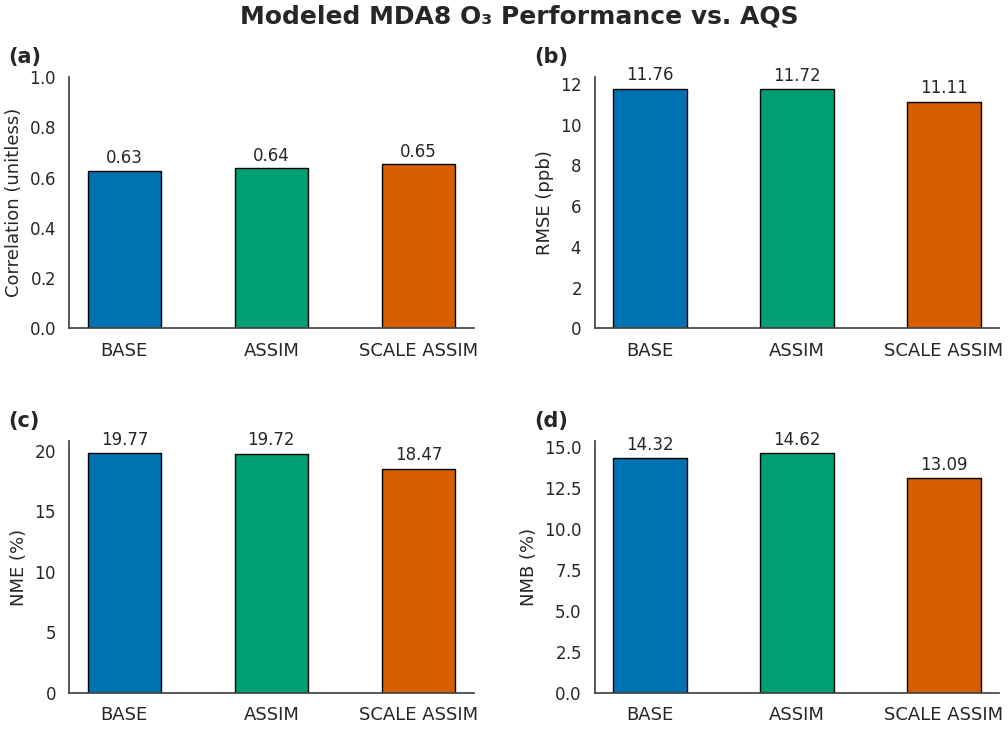

In [12]:
def plot_mda8_o3_metrics_four_panel(base_values, assim_values, scale_assim_values, metrics, savepath=None):
    """
    Four-panel bar plot for MDA8 O3 metrics (Correlation, RMSE, NME, NMB)
    Each panel has its own y-axis and shows BASE, ASSIM, SCALE ASSIM as grouped bars.
    """
    model_labels = ['BASE', 'ASSIM', 'SCALE ASSIM']
    colors = ['#0072B2', '#009E73', '#D55E00']  # Colorblind-friendly

    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'hspace': 0.45, 'wspace': 0.3})
    axes = axes.flatten()
    bar_width = 0.5
    x = np.arange(len(model_labels))

    panel_labels = ['(a)', '(b)', '(c)', '(d)']

    for i, (ax, metric, vals) in enumerate(zip(axes, metrics, zip(base_values, assim_values, scale_assim_values))):
        # vals is a tuple: (base, assim, scale_assim) for this metric
        vals = [v[i] for v in [base_values, assim_values, scale_assim_values]]
        bars = ax.bar(x, vals, color=colors, width=bar_width, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels(model_labels, fontsize=13)
        # ax.set_title(metric, fontsize=15, pad=15)
        ax.tick_params(axis='y', labelsize=12)
        ax.grid(False)
        ax.text(-0.15, 1.12, panel_labels[i], transform=ax.transAxes,
            fontsize=15, fontweight='bold', va='top', ha='left')
        # Annotate bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02*max(vals), f"{height:.2f}",
                    ha='center', va='bottom', fontsize=12)
        # Y-axis label
        if metric == 'Correlation':
            ax.set_ylabel('Correlation (unitless)', fontsize=13)
            ax.set_ylim(0, 1)
        elif metric == 'RMSE':
            ax.set_ylabel('RMSE (ppb)', fontsize=13)
        elif metric == 'NME':
            ax.set_ylabel('NME (%)', fontsize=13)
        elif metric == 'NMB':
            ax.set_ylabel('NMB (%)', fontsize=13)
        # Remove top/right spines for clean look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Adjust layout and add a main title
    fig.suptitle('Modeled MDA8 O₃ Performance vs. AQS', fontsize=18, weight='bold', y=0.97)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_mda8_o3_metrics_four_panel(base_values, assim_values, scale_assim_values, metrics, savepath='MDA8_O3_Metrics_4Panel.png')

In [13]:
CDF

SiteId  POCode    State   County  Elevation  Latitude  Longitude  \
0        10030010       1  Alabama  Baldwin      37.19    30.497     -87.88   
1        10030010       1  Alabama  Baldwin      37.19    30.497     -87.88   
2        10030010       1  Alabama  Baldwin      37.19    30.497     -87.88   
3        10030010       1  Alabama  Baldwin      37.19    30.497     -87.88   
4        10030010       1  Alabama  Baldwin      37.19    30.497     -87.88   
...           ...     ...      ...      ...        ...       ...        ...   
187451  560450003       1  Wyoming   Weston    1437.00    43.873    -104.19   
187452  560450003       1  Wyoming   Weston    1437.00    43.873    -104.19   
187453  560450003       1  Wyoming   Weston    1437.00    43.873    -104.19   
187454  560450003       1  Wyoming   Weston    1437.00    43.873    -104.19   
187455  560450003       1  Wyoming   Weston    1437.00    43.873    -104.19   

        Column  Row           Time On  ... O3_8hrmax_ob  O3_8hrmax_mod  \
0          107   49  09/01/2023 00:00  ...       37.875         34.050   
1          107   49  09/02/2023 00:00  ...       28.875         37.399   
2          107   49  09/03/2023 00:00  ...       33.875         38.811   
3          107   49  09/04/2023 00:00  ...       33.250         35.554   
4          107   49  09/05/2023 00:00  ...       35.250         36.843   
...        ...  ...               ...  ...          ...            ...   
187451      67   90  08/27/2023 00:00  ...       47.125         46.506   
187452      67   90  08/28/2023 00:00  ...       51.375         48.512   
187453      67   90  08/29/2023 00:00  ...       53.875         49.243   
187454      67   90  08/30/2023 00:00  ...       53.875         52.579   
187455      67   90  08/31/2023 00:00  ...       56.500         53.673   

        O3_8hrmax_9cell_ob  O3_8hrmax_9cell_mod_scale_assim  \
0                   37.875                           37.888   
1                   28.875                           38.469   
2                   33.875                           40.554   
3                   33.250                           38.558   
4                   35.250                           41.710   
...                    ...                              ...   
187451              47.125                           46.899   
187452              51.375                           51.055   
187453              53.875                           50.921   
187454              53.875                           52.579   
187455              56.500                           54.051   

        O3_8hrmax_time_ob  O3_8hrmax_time_mod   W126_ob  W126_mod  SUM06_ob  \
0                    12.0                10.0  0.008670  0.006206      0.00   
1                    11.0                10.0  0.002468  0.009712      0.00   
2                     9.0                23.0  0.005179  0.010188      0.00   
3                    10.0                 7.0  0.004920  0.007378      0.00   
4                     9.0                16.0  0.006889  0.008241      0.00   
...                   ...                 ...       ...       ...       ...   
187451               11.0                 8.0  0.039643  0.035734      0.00   
187452               10.0                 8.0  0.066478  0.046683      0.00   
187453               11.0                 9.0  0.104450  0.054713      0.00   
187454               10.0                10.0  0.097662  0.074640      0.00   
187455               12.0                10.0  0.108630  0.086954      0.06   

        SUM06_mod  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
187451        0.0  
187452        0.0  
187453        0.0  
187454        0.0  
187455        0.0  

[187456 rows x 33 columns]

In [14]:
def plot_aqs_map(bdf, cdf):
    """
    Plots AQS dots on a Lambert Conformal projection map with mean MDA8 O3 values.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with lat/lon and MDA8 O3 values.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with lat/lon and MDA8 O3 values.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Group by site ID and calculate mean MDA8 O3
    bdf_mean = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod'].mean().reset_index()
    cdf_mean = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod_scale_assim'].mean().reset_index()

    # Calculate SCALE_ASSIM - BASE
    diff_mean = cdf_mean.copy()
    diff_mean['O3_8hrmax_9cell_diff'] = cdf_mean['O3_8hrmax_9cell_mod_scale_assim'] - bdf_mean['O3_8hrmax_9cell_mod']

    # Set up the map projection
# Define projection
    proj4 = '+proj=lcc +lat_0=40.0 +lon_0=97.0 +lat_1=33.0 +lat_2=45.0 +x_0=2952000.0 +y_0=2772000.0 +R=6370000.0 +to_meter=36000.0 +no_defs'
    projection = ccrs.LambertConformal(central_latitude=40.0, central_longitude=-97.0, 
                                  standard_parallels=(33.0, 45.0))    
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': projection})

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--')
        ax.set_extent([-125, -66.5, 24, 49], crs=ccrs.PlateCarree())

    # Plot BASE
    sc1 = axes[0].scatter(bdf_mean['Longitude'], bdf_mean['Latitude'], c=bdf_mean['O3_8hrmax_9cell_mod'], 
                          cmap='viridis', s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('BASE Mean MDA8 O3', fontsize=14, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='MDA8 O3 (ppb)')

    # Plot SCALE ASSIM
    sc2 = axes[1].scatter(cdf_mean['Longitude'], cdf_mean['Latitude'], c=cdf_mean['O3_8hrmax_9cell_mod_scale_assim'], 
                          cmap='viridis', s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('SCALE ASSIM Mean MDA8 O3', fontsize=14, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='MDA8 O3 (ppb)')

    # Plot SCALE_ASSIM - BASE
    sc3 = axes[2].scatter(diff_mean['Longitude'], diff_mean['Latitude'], c=diff_mean['O3_8hrmax_9cell_diff'], 
                          cmap='coolwarm', s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    axes[2].set_title('SCALE ASSIM - BASE', fontsize=14, weight='bold')
    plt.colorbar(sc3, ax=axes[2], orientation='vertical', label='Difference (ppb)')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('AQS_MDA8_O3_Map_Publication.png', dpi=300, bbox_inches='tight')
    plt.show()

In [15]:
# plot_aqs_map(bdf, cdf)

In [16]:
def plot_aqs_exceedances(bdf, cdf):
    """
    Plots the number of MDA8 O3 exceedances (MDA8 O3 > 70 ppb) for each AQS dot
    on a Lambert Conformal projection map.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with lat/lon and MDA8 O3 values.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with lat/lon and MDA8 O3 values.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Count exceedances for BASE and SCALE ASSIM
    bdf['Exceedance'] = bdf['O3_8hrmax_9cell_mod'] > 70
    cdf['Exceedance'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    bdf_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()
    cdf_exceedances = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()

    # Calculate SCALE_ASSIM - BASE exceedance difference
    diff_exceedances = cdf_exceedances.copy()
    diff_exceedances['Exceedance_Diff'] = cdf_exceedances['Exceedance'] - bdf_exceedances['Exceedance']

    # Set up the map projection
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40, standard_parallels=(33, 45))
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': projection})

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--')
        ax.set_extent([-125, -66.5, 24, 49], crs=ccrs.PlateCarree())

    # Plot BASE exceedances
    sc1 = axes[0].scatter(bdf_exceedances['Longitude'], bdf_exceedances['Latitude'], 
                          c=bdf_exceedances['Exceedance'], cmap='viridis', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('BASE MDA8 O3 Exceedances', fontsize=14, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='Exceedances')

    # Plot SCALE ASSIM exceedances
    sc2 = axes[1].scatter(cdf_exceedances['Longitude'], cdf_exceedances['Latitude'], 
                          c=cdf_exceedances['Exceedance'], cmap='viridis', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('SCALE ASSIM MDA8 O3 Exceedances', fontsize=14, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='Exceedances')

    # Plot exceedance difference (SCALE_ASSIM - BASE)
    sc3 = axes[2].scatter(diff_exceedances['Longitude'], diff_exceedances['Latitude'], 
                          c=diff_exceedances['Exceedance_Diff'], cmap='coolwarm', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[2].set_title('Exceedance Difference (SCALE ASSIM - BASE)', fontsize=14, weight='bold')
    plt.colorbar(sc3, ax=axes[2], orientation='vertical', label='Difference')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('AQS_MDA8_O3_Exceedances_Map_Publication.png', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
def plot_aqs_exceedance_differences(bdf, cdf):
    """
    Plots the number of MDA8 O3 exceedances (MDA8 O3 > 70 ppb) for each AQS dot
    on a Lambert Conformal projection map.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with lat/lon and MDA8 O3 values.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with lat/lon and MDA8 O3 values.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Count exceedances for BASE and SCALE ASSIM
    bdf['Exceedance'] = bdf['O3_8hrmax_9cell_mod'] > 70
    cdf['Exceedance'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70
    bdf_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()
    cdf_exceedances = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()

    # Calculate SCALE_ASSIM - BASE exceedance difference
    diff_exceedances = cdf_exceedances.copy()
    diff_exceedances['Exceedance_Diff'] = cdf_exceedances['Exceedance'] - bdf_exceedances['Exceedance']

    # Set up the map projection
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40, standard_parallels=(33, 45))
    fig, axes = plt.subplots(3, 1, figsize=(16, 12), subplot_kw={'projection': projection})

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--')
        ax.set_extent([-125, -66.5, 24, 49], crs=ccrs.PlateCarree())

    # Plot BASE exceedances
    sc1 = axes[0].scatter(bdf_exceedances['Longitude'], bdf_exceedances['Latitude'], 
                          c=bdf_exceedances['Exceedance'], cmap='viridis', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('BASE MDA8 O3 Exceedances', fontsize=14, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='Exceedances')

    # Plot SCALE ASSIM exceedances
    sc2 = axes[1].scatter(cdf_exceedances['Longitude'], cdf_exceedances['Latitude'], 
                          c=cdf_exceedances['Exceedance'], cmap='viridis', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('SCALE ASSIM MDA8 O3 Exceedances', fontsize=14, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='Exceedances')

    # Plot exceedance difference (SCALE_ASSIM - BASE)
    sc3 = axes[2].scatter(diff_exceedances['Longitude'], diff_exceedances['Latitude'], 
                          c=diff_exceedances['Exceedance_Diff'], cmap='coolwarm', s=50, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[2].set_title('Exceedance Difference (SCALE ASSIM - BASE)', fontsize=14, weight='bold')
    plt.colorbar(sc3, ax=axes[2], orientation='vertical', label='Difference')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('AQS_MDA8_O3_Exceedances_Map_Publication.png', dpi=300, bbox_inches='tight')
    plt.show()

In [53]:
def plot_two_panel_exceedances(bdf, cdf):
    """
    Plots a two-panel map showing BASE - OBS exceedances and SCALE ASSIM - OBS exceedances,
    with statistics (min, max, mean, median) displayed on each panel.

    Parameters:
        bdf (pd.DataFrame): DataFrame containing BASE exceedances and their differences with OBS.
        cdf (pd.DataFrame): DataFrame containing SCALE ASSIM exceedances and their differences with OBS.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    
    # Count exceedances for BASE and SCALE ASSIM
    bdf['Exceedance'] = bdf['O3_8hrmax_9cell_mod'] > 70
    cdf['Exceedance'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70
    bdf['Exceedance_ob'] = bdf['O3_8hrmax_9cell_ob'] > 70
                               
    base_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()
    scale_exceedances = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()
    obs_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance_ob'].sum().reset_index()
                               
    # Calculate SCALE_ASSIM - BASE exceedance difference
    diff_exceedances = base_exceedances.copy()
    diff_exceedances['Exceedance_Diff_Base'] =  obs_exceedances['Exceedance_ob'] - base_exceedances['Exceedance']
    diff_exceedances['Exceedance_Diff_Scale_Assim'] = obs_exceedances['Exceedance_ob'] - scale_exceedances['Exceedance']

    # # Calculate statistics for BASE - OBS and SCALE ASSIM - OBS exceedance differences
    # stats_base = {
    #     'min': diff_exceedances['Exceedance_Diff_Base'].min(),
    #     'max': diff_exceedances['Exceedance_Diff_Base'].max(),
    #     'mean': diff_exceedances['Exceedance_Diff_Base'].mean(),
    #     'median': diff_exceedances['Exceedance_Diff_Base'].median()
    # }
    # stats_scale_assim = {
    #     'min': diff_exceedances['Exceedance_Diff_Scale_Assim'].min(),
    #     'max': diff_exceedances['Exceedance_Diff_Scale_Assim'].max(),
    #     'mean': diff_exceedances['Exceedance_Diff_Scale_Assim'].mean(),
    #     'median': diff_exceedances['Exceedance_Diff_Scale_Assim'].median()
    # }

    # Set up the map projection
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40, standard_parallels=(33, 45))
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), subplot_kw={'projection': projection})

    # Define the map extent (continental US)
    map_extent = [-125, -66.5, 24, 49]  # [west, east, south, north]
    base_diff = diff_exceedances.copy()

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--')
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    vmin = -20
    vmax = 20
    # Plot BASE - OBS exceedances
    sc1 = axes[0].scatter(base_diff['Longitude'], base_diff['Latitude'], 
                          c=base_diff['Exceedance_Diff_Base'], cmap='RdBu_r', s=100, 
                          vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('AQS - Prior Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='Exceedances [Days]')

    # # Add statistics as text for BASE - OBS
    # stats_text_base = (
    #     f"Min: {stats_base['min']:.2f}\n"
    #     f"Max: {stats_base['max']:.2f}\n"
    #     f"Mean: {stats_base['mean']:.2f}\n"
    #     f"Median: {stats_base['median']:.2f}"
    # )
    # axes[0].text(-124, 25, stats_text_base, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # Plot SCALE ASSIM - OBS exceedances
    sc2 = axes[1].scatter(base_diff['Longitude'], base_diff['Latitude'], 
                          c=base_diff['Exceedance_Diff_Scale_Assim'], cmap='RdBu_r', s=100, 
                          vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('AQS - Posterior Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='Exceedances [Days]')

    # # Add statistics as text for SCALE ASSIM - OBS
    # stats_text_scale_assim = (
    #     f"Min: {stats_scale_assim['min']:.2f}\n"
    #     f"Max: {stats_scale_assim['max']:.2f}\n"
    #     f"Mean: {stats_scale_assim['mean']:.2f}\n"
    #     f"Median: {stats_scale_assim['median']:.2f}"
    # )
    # axes[1].text(-124, 25, stats_text_scale_assim, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # Adjust layout
    plt.tight_layout()
    plt.savefig('Two_Panel_Exceedances_Map_with_Stats.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
cdf.columns

Index(['index', 'SiteId', 'POCode', 'State', 'County', 'Elevation', 'Latitude',
       'Longitude', 'Column', 'Row', 'Time On', 'Time Off', 'SMM', 'SDD',
       'SYYYY', 'EMM', 'EDD', 'EYYYY', 'O3_1hrmax_ob', 'O3_1hrmax_mod',
       'O3_1hrmax_9cell_ob', 'O3_1hrmax_9cell_mod', 'O3_1hrmax_time_ob',
       'O3_1hrmax_time_mod', 'O3_8hrmax_ob', 'O3_8hrmax_mod',
       'O3_8hrmax_9cell_ob', 'O3_8hrmax_9cell_mod_scale_assim',
       'O3_8hrmax_time_ob', 'O3_8hrmax_time_mod', 'W126_ob', 'W126_mod',
       'SUM06_ob', 'SUM06_mod'],
      dtype='object')

In [20]:
# plot_aqs_exceedances(bdf, cdf)

In [21]:
def plot_aqs_exceedances_zoomed(bdf, cdf):
    """
    Plots the number of MDA8 O3 exceedances (MDA8 O3 > 70 ppb) for each AQS dot
    on a Lambert Conformal projection map, zoomed into the Ohio River Valley and Midwest US.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with lat/lon and MDA8 O3 values.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with lat/lon and MDA8 O3 values.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Count exceedances for BASE and SCALE ASSIM
    bdf['Exceedance'] = bdf['O3_8hrmax_9cell_mod'] > 70
    cdf['Exceedance'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    bdf_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()
    cdf_exceedances = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance'].sum().reset_index()

    # Calculate SCALE_ASSIM - BASE exceedance difference
    diff_exceedances = cdf_exceedances.copy()
    diff_exceedances['Exceedance_Diff'] = cdf_exceedances['Exceedance'] - bdf_exceedances['Exceedance']

    # Set up the map projection
    projection = ccrs.LambertConformal(central_longitude=-97, central_latitude=40, standard_parallels=(33, 45))
    fig, axes = plt.subplots(3, 1, figsize=(24, 12), subplot_kw={'projection': projection})

    # Define the zoomed extent (Ohio River Valley and Midwest US)
    zoom_extent = [-95, -80, 35, 50]  # [west, east, south, north]

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--')
        ax.set_extent(zoom_extent, crs=ccrs.PlateCarree())

    # Plot BASE exceedances
    sc1 = axes[0].scatter(bdf_exceedances['Longitude'], bdf_exceedances['Latitude'], 
                          c=bdf_exceedances['Exceedance'], cmap='viridis', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('Prior MDA8 O3 Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='Exceedances')

    # Plot SCALE ASSIM exceedances
    sc2 = axes[1].scatter(cdf_exceedances['Longitude'], cdf_exceedances['Latitude'], 
                          c=cdf_exceedances['Exceedance'], cmap='viridis', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('Posterior MDA8 O3 Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='Exceedances')

    # Plot exceedance difference (SCALE_ASSIM - BASE)
    sc3 = axes[2].scatter(diff_exceedances['Longitude'], diff_exceedances['Latitude'], 
                          c=diff_exceedances['Exceedance_Diff'], cmap='coolwarm', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[2].set_title('Exceedance Difference (Posterior - Prior)', fontsize=16, weight='bold')
    plt.colorbar(sc3, ax=axes[2], orientation='vertical', label='Difference')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('AQS_MDA8_O3_Exceedances_Map_Zoomed.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
# plot_aqs_exceedances_zoomed(bdf, cdf)

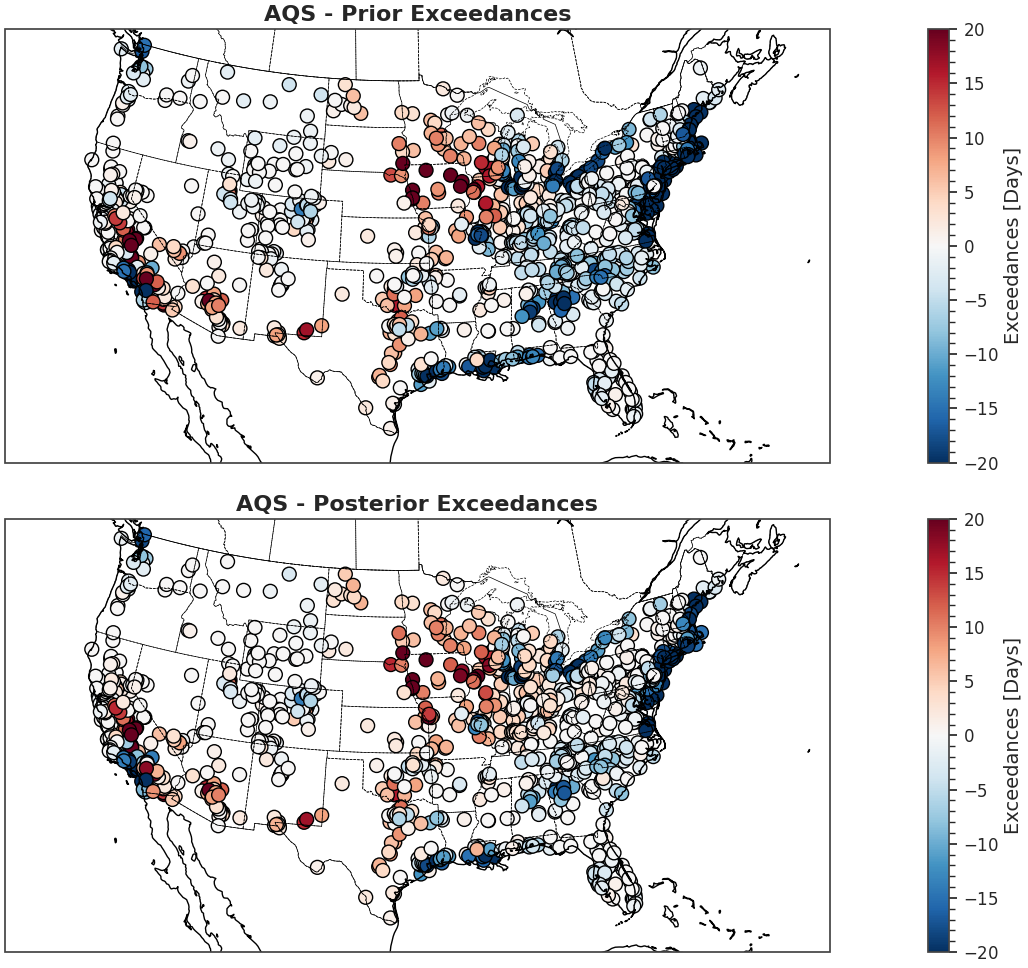

In [54]:
plot_two_panel_exceedances(BDF, CDF)

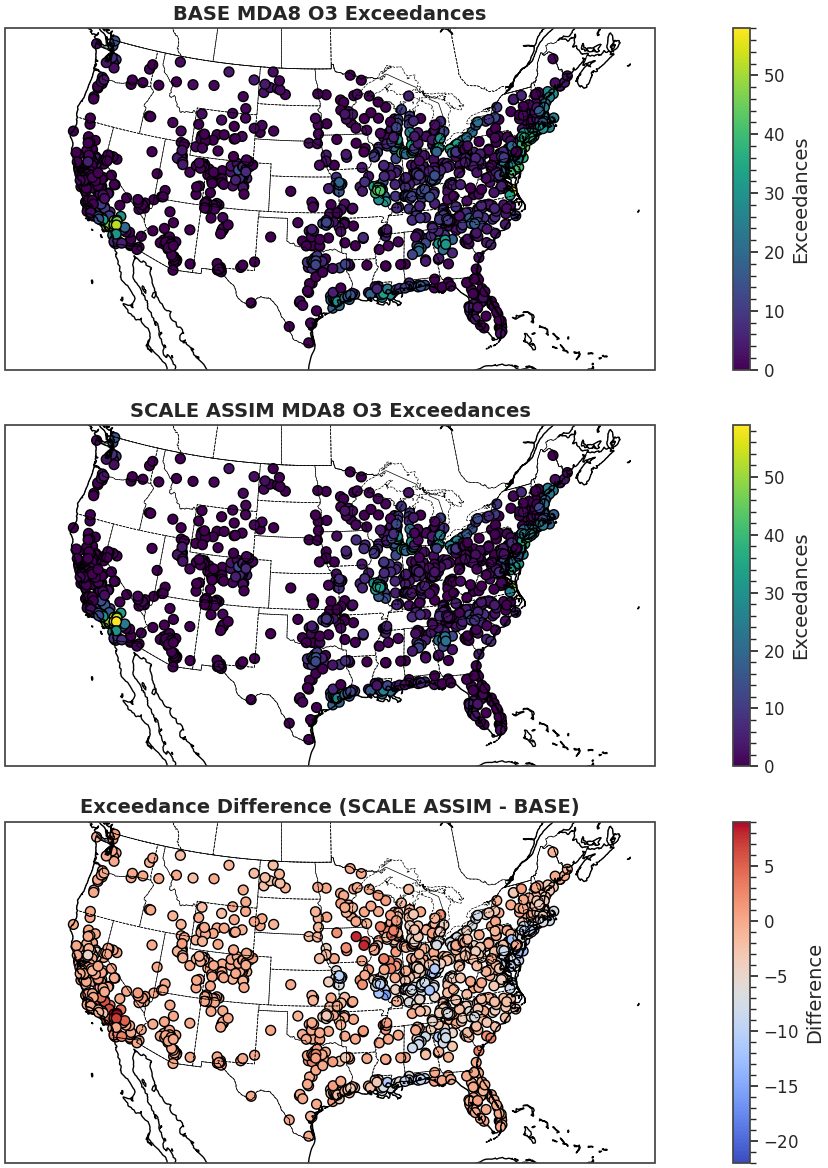

In [24]:
plot_aqs_exceedance_differences(BDF, CDF)

In [25]:
def plot_three_panel_exceedances_with_stats(bdf, cdf):
    """
    Plots a three-panel map showing the number of exceedances for BASE, SCALE ASSIM, and OBS,
    with statistics (min, max, mean, median) displayed on each panel.

    Parameters:
        bdf (pd.DataFrame): DataFrame containing BASE and OBS exceedances.
        cdf (pd.DataFrame): DataFrame containing SCALE ASSIM exceedances.
    """
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import cartopy.feature as cfeature
    cfeature.COASTLINE.geometries()  # Force download of coastlines
    cfeature.BORDERS.geometries()    # Force download of country borders
    cfeature.STATES.geometries()     # Force download of state borders
    import matplotlib.pyplot as plt

    # Count exceedances for BASE, SCALE ASSIM, and OBS
    bdf['Exceedance_base'] = bdf['O3_8hrmax_9cell_mod'] > 70
    cdf['Exceedance_scale_assim'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70
    bdf['Exceedance_ob'] = bdf['O3_8hrmax_9cell_ob'] > 70

    # Group by SiteId, Latitude, and Longitude
    base_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance_base'].sum().reset_index()
    scale_assim_exceedances = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance_scale_assim'].sum().reset_index()
    obs_exceedances = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['Exceedance_ob'].sum().reset_index()

    # Calculate statistics for BASE, SCALE ASSIM, and OBS
    base_stats = {
        'min': base_exceedances['Exceedance_base'].min(),
        'max': base_exceedances['Exceedance_base'].max(),
        'mean': base_exceedances['Exceedance_base'].mean(),
        'median': base_exceedances['Exceedance_base'].median()
    }
    scale_assim_stats = {
        'min': scale_assim_exceedances['Exceedance_scale_assim'].min(),
        'max': scale_assim_exceedances['Exceedance_scale_assim'].max(),
        'mean': scale_assim_exceedances['Exceedance_scale_assim'].mean(),
        'median': scale_assim_exceedances['Exceedance_scale_assim'].median()
    }
    obs_stats = {
        'min': obs_exceedances['Exceedance_ob'].min(),
        'max': obs_exceedances['Exceedance_ob'].max(),
        'mean': obs_exceedances['Exceedance_ob'].mean(),
        'median': obs_exceedances['Exceedance_ob'].median()
    }

    # Set up the map projection
    proj = ccrs.LambertConformal(central_longitude=-97, central_latitude=40, standard_parallels=(33, 45))
    fig, axes = plt.subplots(3, 1, figsize=(16, 18), subplot_kw={'projection': proj})

    # Define the map extent (continental US)
    map_extent = [-125, -66.5, 24, 49]  # [west, east, south, north]

    # Add map features
    for ax in axes:
        ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--', edgecolor='gray')
        ax.set_extent(map_extent, crs=ccrs.PlateCarree())

    # Plot BASE exceedances
    sc1 = axes[0].scatter(base_exceedances['Longitude'], base_exceedances['Latitude'], 
                          c=base_exceedances['Exceedance_base'], cmap='viridis', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[0].set_title('BASE Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc1, ax=axes[0], orientation='vertical', label='Exceedances')

    # Add statistics as text
    stats_text_base = (
        f"Min: {base_stats['min']:.2f}\n"
        f"Max: {base_stats['max']:.2f}\n"
        f"Mean: {base_stats['mean']:.2f}\n"
        f"Median: {base_stats['median']:.2f}"
    )
    axes[0].text(-124, 24, stats_text_base, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # Plot SCALE ASSIM exceedances
    sc2 = axes[1].scatter(scale_assim_exceedances['Longitude'], scale_assim_exceedances['Latitude'], 
                          c=scale_assim_exceedances['Exceedance_scale_assim'], cmap='viridis', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[1].set_title('SCALE ASSIM Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc2, ax=axes[1], orientation='vertical', label='Exceedances')

    # Add statistics as text
    stats_text_scale_assim = (
        f"Min: {scale_assim_stats['min']:.2f}\n"
        f"Max: {scale_assim_stats['max']:.2f}\n"
        f"Mean: {scale_assim_stats['mean']:.2f}\n"
        f"Median: {scale_assim_stats['median']:.2f}"
    )
    axes[1].text(-124, 24, stats_text_scale_assim, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # Plot OBS exceedances
    sc3 = axes[2].scatter(obs_exceedances['Longitude'], obs_exceedances['Latitude'], 
                          c=obs_exceedances['Exceedance_ob'], cmap='viridis', s=100, 
                          transform=ccrs.PlateCarree(), edgecolor='black')
    axes[2].set_title('OBS Exceedances', fontsize=16, weight='bold')
    plt.colorbar(sc3, ax=axes[2], orientation='vertical', label='Exceedances')

    # Add statistics as text
    stats_text_obs = (
        f"Min: {obs_stats['min']:.2f}\n"
        f"Max: {obs_stats['max']:.2f}\n"
        f"Mean: {obs_stats['mean']:.2f}\n"
        f"Median: {obs_stats['median']:.2f}"
    )
    axes[2].text(-124, 24, stats_text_obs, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=ccrs.PlateCarree())

    # Adjust layout
    plt.tight_layout()
    plt.savefig('Three_Panel_Exceedances_Map_with_Stats.png', dpi=300, bbox_inches='tight')
    plt.show()

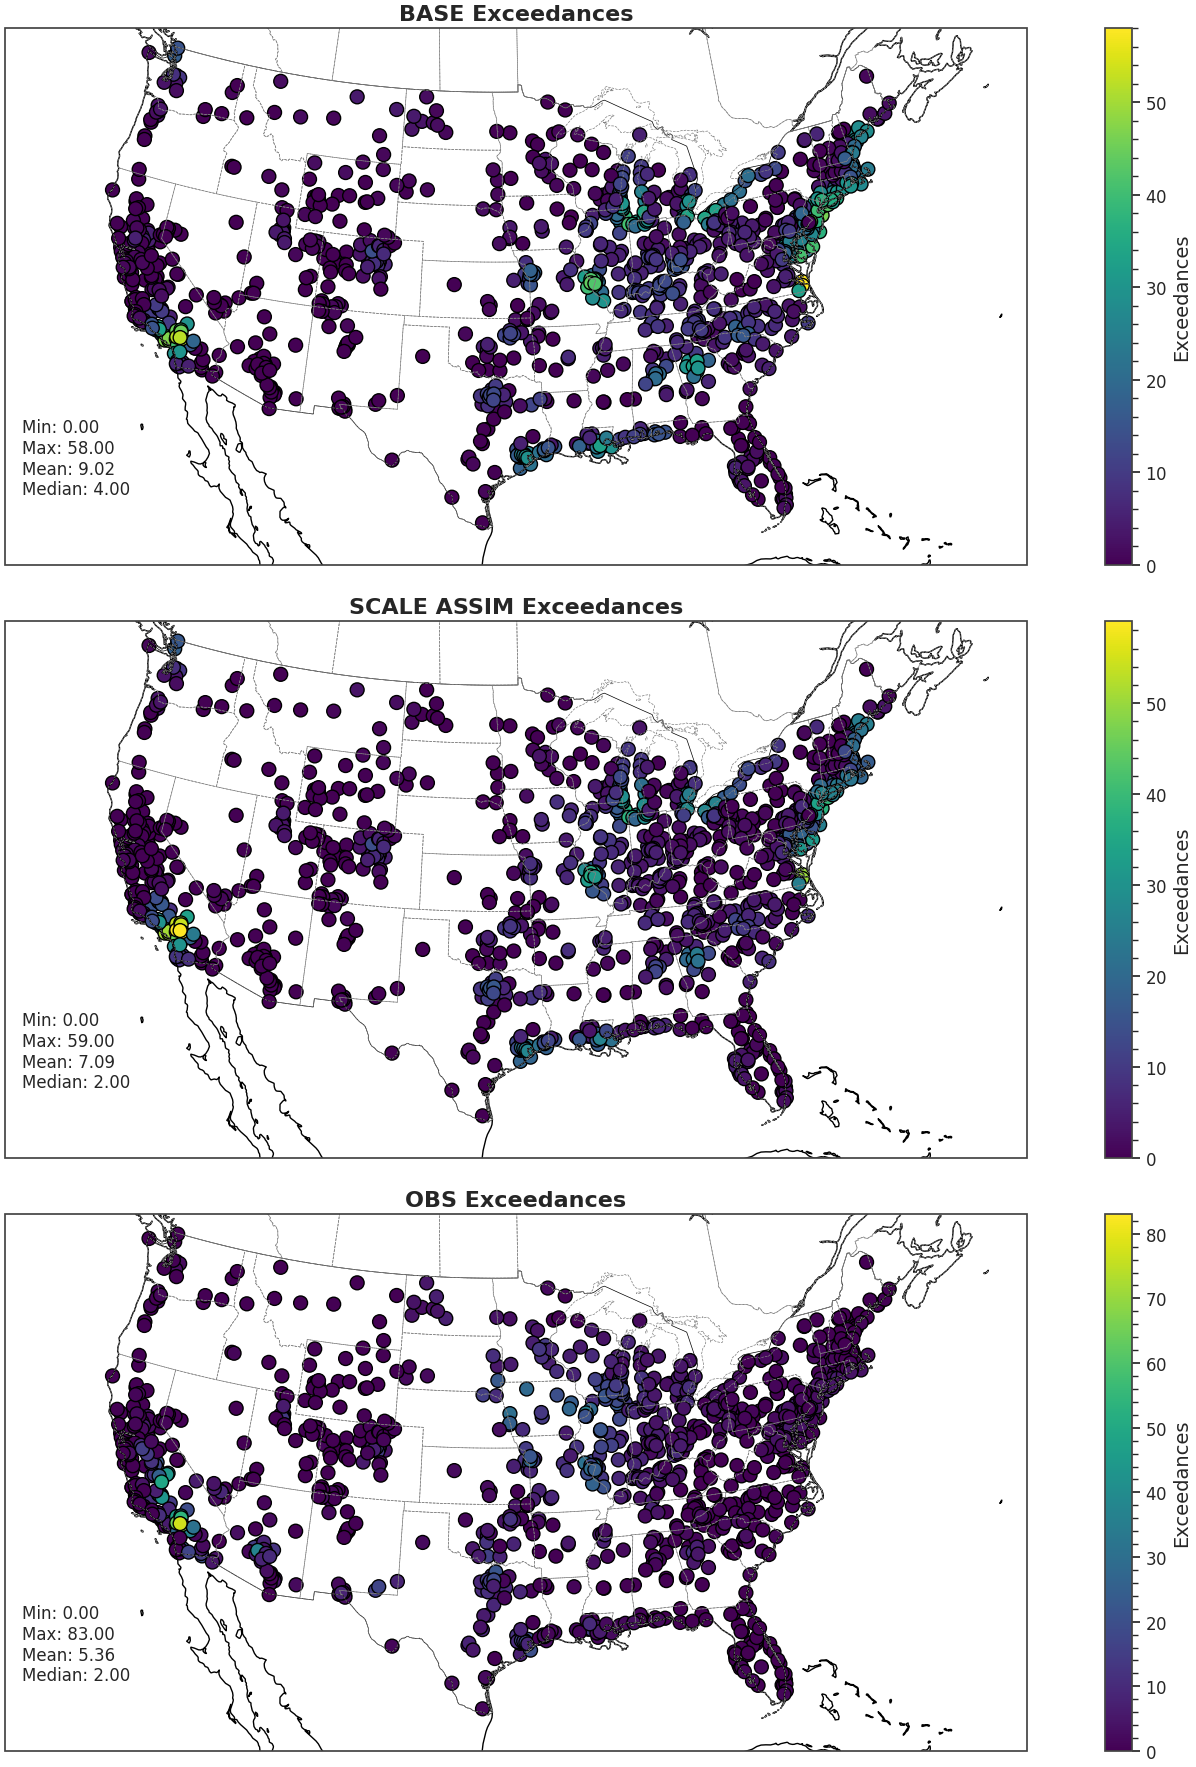

In [26]:
plot_three_panel_exceedances_with_stats(BDF, CDF)

In [27]:
import cartopy.feature as cfeature

# Force download of required features
cfeature.COASTLINE.geometries()
cfeature.BORDERS.geometries()
cfeature.STATES.geometries()

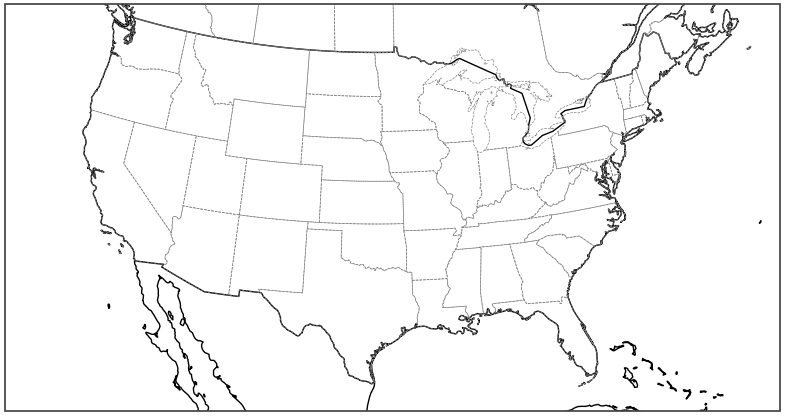

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up a simple Lambert Conformal map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-97, central_latitude=40)})

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, linestyle='--', edgecolor='gray')

# Set map extent
ax.set_extent([-125, -66.5, 24, 49], crs=ccrs.PlateCarree())

plt.show()

In [29]:
def group_aqs_sites_by_region(bdf, cdf):
    """
    Groups AQS sites into US regions based on the state they are in.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with state information.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with state information.

    Returns:
        bdf_grouped (pd.DataFrame): BASE DataFrame with an added 'Region' column.
        cdf_grouped (pd.DataFrame): SCALE ASSIM DataFrame with an added 'Region' column.
    """
    # Define US regions and their corresponding states
    regions = {
        "Northeast": [
            "Connecticut", "Maine", "Massachusetts", "New Hampshire", "Rhode Island", "Vermont",
            "New Jersey", "New York", "Pennsylvania", "Delaware", "Maryland", "District of Columbia" 
        ],
        "Southeast": [
            "Virginia", "North Carolina", "South Carolina", "Georgia", "Florida", "Alabama"
        ],
        "Ohio Valley": [ #Upper midwest + ohio valley
            "Ohio", "West Virginia", "Kentucky", "Tennessee", "Indiana", "Illinois", "Missouri"
        ],
        "Upper Midwest": [
            "Michigan", "Wisconsin", "Minnesota", "Iowa"
        ],
        "South": [ #transition region
            "Kansas", "Oklahoma", "Texas", "Arkansas", "Louisiana", "Mississippi"
        ],
        "Northern Rockies & Plains": [ # transition region; includes Montana + Wyoming
            "Montana", "Wyoming", "North Dakota", "South Dakota", "Nebraska"
        ],
        "Southwest": [
            "Colorado", "Utah", "New Mexico", "Arizona"
        ],
        "West": [ # West + Northwest
            "Nevada", "California", "Alaska", "Hawaii"
        ],
        "Northwest": [
            "Washington", "Oregon", "Idaho"
        ]
    }
    # Create a mapping of state to region
    state_to_region = {state: region for region, states in regions.items() for state in states}

    # Add a 'Region' column to both DataFrames based on the state
    bdf["Region"] = bdf["State"].map(state_to_region)
    cdf["Region"] = cdf["State"].map(state_to_region)

    return bdf, cdf

In [30]:
def plot_exceedances_by_region(bdf, cdf):
    """
    Creates a bar plot showing the total number of ozone exceedances by region for obs, scale assim, and base.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with exceedance and region information.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with exceedance and region information.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Count exceedances for each region
    bdf["Exceedance_base"] = bdf["O3_8hrmax_9cell_mod"] > 70
    cdf["Exceedance_scale_assim"] = cdf["O3_8hrmax_9cell_mod_scale_assim"] > 70
    bdf["Exceedance_obs"] = bdf["O3_8hrmax_9cell_ob"] > 70

    base_counts = bdf.groupby("Region")["Exceedance_base"].sum()
    scale_assim_counts = cdf.groupby("Region")["Exceedance_scale_assim"].sum()
    obs_counts = bdf.groupby("Region")["Exceedance_obs"].sum()

    # Combine into a single DataFrame for plotting
    exceedance_data = pd.DataFrame({
        "BASE": base_counts,
        "SCALE ASSIM": scale_assim_counts,
        "OBS": obs_counts
    }).reset_index()

    # Melt the DataFrame for seaborn
    exceedance_data_melted = exceedance_data.melt(id_vars="Region", var_name="Type", value_name="Exceedances")

    # Create the bar plot
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    sns.barplot(data=exceedance_data_melted, x="Region", y="Exceedances", hue="Type", palette="muted")

    # Add labels and title
    plt.xlabel("Region", fontsize=14, labelpad=10)
    plt.ylabel("Total Ozone Exceedances", fontsize=14, labelpad=10)
    plt.title("Total Regional Ozone Exceedances, May-Sep 2023", fontsize=16, weight="bold", pad=20)
    plt.legend(title="Type", fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot as a high-resolution image
    plt.tight_layout()
    plt.savefig("Ozone_Exceedances_By_Region.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

In [31]:
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_exceedances_by_region_updated(bdf, cdf, output_path=None):
    """
    Bar plot of total ozone exceedances by region for BASE, SCALE+ASSIM, and OBS.
    """
    # 1. Flag exceedances (>70 ppb MDA8)
    bdf = bdf.copy()
    cdf = cdf.copy()
    bdf['Exceedance_base'] = bdf['O3_8hrmax_9cell_mod'] > 70
    bdf['Exceedance_obs'] = bdf['O3_8hrmax_9cell_ob'] > 70
    cdf['Exceedance_scale_assim'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    # 2. Aggregate counts
    df_counts = pd.DataFrame({
        'Region': bdf['Region'],
        'BASE': bdf.groupby('Region')['Exceedance_base'].transform('sum'),
        'OBS': bdf.groupby('Region')['Exceedance_obs'].transform('sum'),
        'SCALE ASSIM': cdf.groupby('Region')['Exceedance_scale_assim'].transform('sum')
    }).drop_duplicates()

    # Replace NaN values with 0
    df_counts = df_counts.fillna(0)
    
    all_regions = [
        "Northeast",
        "Southeast",
        "Ohio Valley",
        "Upper Midwest",
        "South",
        "Northern Rockies & Plains",
        "Southwest",
        "Northwest",
        "West"
    ]

    # Example for plot_exceedances_by_region_updated and similar functions:
    valid_regions = all_regions
    # Restrict to the 5 regions
    # valid_regions = ['West', 'Southwest', 'Midwest', 'Southeast', 'Northeast']
    df_counts = df_counts[df_counts['Region'].isin(valid_regions)]

    # 3. Order regions by OBS descending
    df_counts = df_counts.sort_values('OBS', ascending=False)
    regions = df_counts['Region'].tolist()

    # 4. Plot setup
    x = np.arange(len(regions))
    width = 0.25

    colors = ['steelblue', 'coral', 'dimgray']  # BASE, SCALE ASSIM, OBS

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width, df_counts['BASE'], width, label='BASE', color=colors[0])
    bars2 = ax.bar(x, df_counts['SCALE ASSIM'], width, label='SCALE+ASSIM', color=colors[1])
    bars3 = ax.bar(x + width, df_counts['OBS'], width, label='OBS', color=colors[2])

    # 5. Annotate bar values
    for bars in (bars1, bars2, bars3):
        for bar in bars:
            h = bar.get_height()
            if not np.isnan(h):  # Only annotate if the height is not NaN
                ax.text(
                    bar.get_x() + bar.get_width() / 2, h + 5,
                    f"{int(h)}", ha='center', va='bottom', fontsize=9
                )

    # 6. Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=45, ha='right')
    ax.set_ylabel('Total O₃ Exceedances (MDA8 > 70 ppb)', fontsize=12)
    ax.set_title('Total Regional Ozone Exceedances, May–Sep 2023', fontsize=14, fontweight='bold', pad=12)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper left', frameon=False)

    plt.tight_layout()
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [32]:
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_exceedances_by_region_updated(bdf, cdf, output_path=None):
    """
    Bar plot of total ozone exceedances by region for BASE, SCALE+ASSIM, and OBS.
    """
    # 1. Flag exceedances (>70 ppb MDA8)
    bdf = bdf.copy()
    cdf = cdf.copy()
    bdf['Exceedance_base'] = bdf['O3_8hrmax_9cell_mod'] > 70
    bdf['Exceedance_obs'] = bdf['O3_8hrmax_9cell_ob'] > 70
    cdf['Exceedance_scale_assim'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    # 2. Aggregate counts
    df_counts = pd.DataFrame({
        'Region': bdf['Region'],
        'BASE': bdf.groupby('Region')['Exceedance_base'].transform('sum'),
        'OBS': bdf.groupby('Region')['Exceedance_obs'].transform('sum'),
        'SCALE ASSIM': cdf.groupby('Region')['Exceedance_scale_assim'].transform('sum')
    }).drop_duplicates()

    # Replace NaN values with 0
    df_counts = df_counts.fillna(0)
    all_regions = [
        "Northeast",
        "Southeast",
        "Ohio Valley",
        "Upper Midwest",
        "South",
        "Northern Rockies & Plains",
        "Southwest",
        "Northwest",
        "West"
    ]

    # Example for plot_exceedances_by_region_updated and similar functions:
    valid_regions = all_regions
    # Restrict to the 5 regions
    # valid_regions = ['West', 'Southwest', 'Midwest', 'Southeast', 'Northeast']
    df_counts = df_counts[df_counts['Region'].isin(valid_regions)]

    # 3. Order regions by OBS descending
    df_counts = df_counts.sort_values('OBS', ascending=False)
    regions = df_counts['Region'].tolist()

    # 4. Plot setup
    x = np.arange(len(regions))
    width = 0.25

    colors = ['steelblue', 'coral', 'dimgray']  # BASE, SCALE ASSIM, OBS

    fig, ax = plt.subplots(figsize=(13, 7))
    bars1 = ax.bar(x - width, df_counts['BASE'], width, label='BASE', color=colors[0])
    bars2 = ax.bar(x, df_counts['SCALE ASSIM'], width, label='SCALE ASSIM', color=colors[1])
    bars3 = ax.bar(x + width, df_counts['OBS'], width, label='AQS OBS', color=colors[2])

    # 5. Annotate bar values (inside if tall, above if short)
    max_height = max(df_counts[['BASE', 'SCALE ASSIM', 'OBS']].max())
    y_lim = max_height * 1.12
    ax.set_ylim(0, y_lim)
    for bars in (bars1, bars2, bars3):
        for bar in bars:
            h = bar.get_height()
            if h > y_lim * 0.08:
                ax.text(bar.get_x() + bar.get_width() / 2, h - y_lim * 0.04,
                        f"{int(h)}", ha='center', va='top', fontsize=11, color='white', fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, h + y_lim * 0.01,
                        f"{int(h)}", ha='center', va='bottom', fontsize=11, color='black', fontweight='bold')

    # 6. Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=30, ha='right', fontsize=13)
    ax.set_xlabel('Region', fontsize=14, labelpad=10, weight='bold')
    ax.set_ylabel('Total MDA8 O₃ Exceedances (> 70 ppb)', fontsize=14, weight='bold')
    # ax.set_title('Total Regional Ozone Exceedances, May–Sep 2023', fontsize=17, fontweight='bold', pad=16)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', frameon=False, fontsize=13)

    plt.tight_layout()
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [33]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm

def plot_two_panel_exceedances_with_error(bdf, cdf, output_path=None):
    """
    Creates a two-panel plot:
    - Left: BASE vs OBS exceedances by region.
    - Right: BASE - OBS and SCALE_ASSIM - OBS error as paired bars with a diverging colormap.

    Parameters:
        bdf (pd.DataFrame): DataFrame for BASE data with exceedance and region information.
        cdf (pd.DataFrame): DataFrame for SCALE ASSIM data with exceedance and region information.
        output_path (str): Path to save the plot (optional).
    """
    # 1. Flag exceedances (>70 ppb MDA8)
    bdf = bdf.copy()
    cdf = cdf.copy()
    bdf['Exceedance_base'] = bdf['O3_8hrmax_9cell_mod'] > 70
    bdf['Exceedance_obs'] = bdf['O3_8hrmax_9cell_ob'] > 70
    cdf['Exceedance_scale_assim'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    # 2. Aggregate counts
    df_counts = pd.DataFrame({
        'Region': bdf['Region'],
        'BASE': bdf.groupby('Region')['Exceedance_base'].transform('sum'),
        'OBS': bdf.groupby('Region')['Exceedance_obs'].transform('sum'),
        'SCALE ASSIM': cdf.groupby('Region')['Exceedance_scale_assim'].transform('sum')
    }).drop_duplicates()

    # Replace NaN values with 0
    df_counts = df_counts.fillna(0)

    all_regions = [
            "Northeast",
            "Southeast",
            "Ohio Valley",
            "Upper Midwest",
            "South",
            "Northern Rockies & Plains",
            "Southwest",
            "Northwest",
            "West"
        ]

    # Example for plot_exceedances_by_region_updated and similar functions:
    valid_regions = all_regions
    # Restrict to the 5 regions
    # valid_regions = ['West', 'Southwest', 'Midwest', 'Southeast', 'Northeast']
    df_counts = df_counts[df_counts['Region'].isin(valid_regions)]

    # 3. Calculate errors
    df_counts['BASE - OBS'] = df_counts['BASE'] - df_counts['OBS']
    df_counts['SCALE ASSIM - OBS'] = df_counts['SCALE ASSIM'] - df_counts['OBS']

    # 4. Order regions by OBS descending
    df_counts = df_counts.sort_values('OBS', ascending=False)
    regions = df_counts['Region'].tolist()

    # 5. Plot setup
    x = np.arange(len(regions))
    width = 0.35

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # Left Panel: BASE vs OBS exceedances
    colors = ['steelblue', 'dimgray']  # BASE, OBS
    bars1 = axes[0].bar(x - width / 2, df_counts['BASE'], width, label='BASE', color=colors[0])
    bars2 = axes[0].bar(x + width / 2, df_counts['OBS'], width, label='OBS', color=colors[1])

    # Annotate bar values
    for bars in (bars1, bars2):
        for bar in bars:
            h = bar.get_height()
            if not np.isnan(h):  # Only annotate if the height is not NaN
                axes[0].text(
                    bar.get_x() + bar.get_width() / 2, h + 5,
                    f"{int(h)}", ha='center', va='bottom', fontsize=9
                )

    # Aesthetics for Left Panel
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(regions, rotation=45, ha='right')
    axes[0].set_ylabel('Total O₃ Exceedances (MDA8 > 70 ppb)', fontsize=12)
    axes[0].set_title('BASE vs OBS Exceedances by Region', fontsize=14, fontweight='bold', pad=12)
    axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)
    axes[0].legend(loc='upper left', frameon=False)

    # Right Panel: BASE - OBS and SCALE ASSIM - OBS error
    error_colors = ['blue', 'red']  # Diverging colormap for under/overpredictions
    norm = TwoSlopeNorm(vmin=-max(abs(df_counts[['BASE - OBS', 'SCALE ASSIM - OBS']].values.flatten())),
                        vcenter=0,
                        vmax=max(abs(df_counts[['BASE - OBS', 'SCALE ASSIM - OBS']].values.flatten())))

    bars3 = axes[1].bar(x - width / 2, df_counts['BASE - OBS'], width, label='BASE - OBS',
                        color=[plt.cm.coolwarm(norm(val)) for val in df_counts['BASE - OBS']])
    bars4 = axes[1].bar(x + width / 2, df_counts['SCALE ASSIM - OBS'], width, label='SCALE ASSIM - OBS',
                        color=[plt.cm.coolwarm(norm(val)) for val in df_counts['SCALE ASSIM - OBS']])

    # Annotate bar values
    for bars in (bars3, bars4):
        for bar in bars:
            h = bar.get_height()
            if not np.isnan(h):  # Only annotate if the height is not NaN
                axes[1].text(
                    bar.get_x() + bar.get_width() / 2, h + (5 if h > 0 else -10),
                    f"{int(h)}", ha='center', va='bottom' if h > 0 else 'top', fontsize=9
                )

    # Aesthetics for Right Panel
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(regions, rotation=45, ha='right')
    axes[1].set_ylabel('Error (Exceedances)', fontsize=12)
    axes[1].set_title('BASE/SCALE ASSIM - OBS Error by Region', fontsize=14, fontweight='bold', pad=12)
    axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].legend(loc='upper left', frameon=False)

    # Add colorbar for the diverging colormap
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[1], orientation='vertical', pad=0.02)
    cbar.set_label('Error Magnitude', fontsize=12)

    # Save or show the plot
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter, AutoMinorLocator
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs  # if using cartopy, otherwise remove

def plot_two_panel_exceedances_with_error(bdf, cdf, output_path=None):
    """
    (a) BASE vs OBS Exceedances by Region
    (b) BASE–OBS and SCALE_ASSIM–OBS Error by Region
    """
    # 1. Flag exceedances
    bdf = bdf.copy()
    cdf = cdf.copy()
    bdf['OBS_exc']    = bdf['O3_8hrmax_9cell_ob']           > 70
    bdf['BASE_exc']   = bdf['O3_8hrmax_9cell_mod']          > 70
    cdf['SCALE_exc']  = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    # 2. Aggregate
    df = pd.DataFrame({
        'Region':      bdf['Region'],
        'OBS':         bdf.groupby('Region')['OBS_exc'].transform('sum'),
        'BASE':        bdf.groupby('Region')['BASE_exc'].transform('sum'),
        'SCALE':       cdf.groupby('Region')['SCALE_exc'].transform('sum'),
    }).drop_duplicates()

    # 3. Compute errors
    df['err_base']  = df['BASE']  - df['OBS']
    df['err_scale'] = df['SCALE'] - df['OBS']

    # 4. Sort
    order = ['West','Northwest','Southwest','Northern Rockies & Plains', 'South', 'Upper Midwest', 'Ohio Valley', 'Southeast','Northeast']
    df = df.set_index('Region').loc[order].reset_index()

    # 5. Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), constrained_layout=True)

    x = np.arange(len(df))
    w = 0.35

    # Left: BASE vs OBS
    colors = {'BASE':'#4682B4','OBS':'#808080'}
    bars_b = ax1.bar(x - w/2, df['BASE'], w, color=colors['BASE'], label='BASE')
    bars_o = ax1.bar(x + w/2, df['OBS'],  w, color=colors['OBS'], label='OBS')

    # Annotate counts
    for bars in (bars_b, bars_o):
        for bar in bars:
            h = bar.get_height()
            ax1.text(bar.get_x()+bar.get_width()/2, h+5,
                     f"{int(h)}", ha='center', va='bottom', fontsize=9)

    ax1.set_xticks(x); ax1.set_xticklabels(df['Region'], rotation=30, ha='right')
    ax1.set_ylabel('O₃ Exceedances\n(MDA8 > 70 ppb)')
    ax1.set_title('(a) BASE vs OBS Exceedances', loc='left', fontsize=12, fontweight='bold')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.grid(axis='y', linestyle='--', alpha=0.4)
    for sp in ['top','right']: ax1.spines[sp].set_visible(False)
    ax1.legend(frameon=False, fontsize=9)

    # Right: Error bars with diverging colormap
    vmax = max(abs(df[['err_base','err_scale']].values).flatten())
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = plt.cm.coolwarm

    bars_e1 = ax2.bar(x - w/2, df['err_base'],  w,
                      color=cmap(norm(df['err_base'])), label='BASE – OBS')
    bars_e2 = ax2.bar(x + w/2, df['err_scale'], w,
                      color=cmap(norm(df['err_scale'])), label='SCALE – OBS')

    # Annotate error values
    for bars in (bars_e1, bars_e2):
        for bar in bars:
            h = bar.get_height()
            va = 'bottom' if h>=0 else 'top'
            y = h + (5 if h>=0 else -5)
            ax2.text(bar.get_x()+bar.get_width()/2, y,
                     f"{int(h)}", ha='center', va=va, fontsize=9)

    ax2.set_xticks(x); ax2.set_xticklabels(df['Region'], rotation=30, ha='right')
    ax2.set_ylabel('Error: model – obs')
    ax2.set_title('(b) Error Reduction (BASE vs SCALE)', loc='left', fontsize=12, fontweight='bold')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.grid(axis='y', linestyle='--', alpha=0.4)
    for sp in ['top','right']: ax2.spines[sp].set_visible(False)
    ax2.legend(frameon=False, fontsize=9)

    # Shared colorbar for errors
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax2, orientation='vertical', pad=0.02)
    cbar.set_label('Error magnitude (%)')

    # Save/show
    if output_path:
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

In [35]:
def plot_exceedances_by_region_updated(bdf, cdf, output_path=None):
    """
    Bar plot of total ozone exceedances by region for BASE, SCALE ASSIM, and OBS.
    Publication-ready: consistent with Figure 13, no gridlines, clean style.
    """
    # 1. Flag exceedances (>70 ppb MDA8)
    bdf = bdf.copy()
    cdf = cdf.copy()
    bdf['Exceedance_base'] = bdf['O3_8hrmax_9cell_mod'] > 70
    bdf['Exceedance_obs'] = bdf['O3_8hrmax_9cell_ob'] > 70
    cdf['Exceedance_scale_assim'] = cdf['O3_8hrmax_9cell_mod_scale_assim'] > 70

    # 2. Aggregate counts
    df_counts = pd.DataFrame({
        'Region': bdf['Region'],
        'BASE': bdf.groupby('Region')['Exceedance_base'].transform('sum'),
        'OBS': bdf.groupby('Region')['Exceedance_obs'].transform('sum'),
        'SCALE ASSIM': cdf.groupby('Region')['Exceedance_scale_assim'].transform('sum')
    }).drop_duplicates()

    # Replace NaN values with 0
    df_counts = df_counts.fillna(0)
    region_order = [
        "West",
        "Northwest",
        "Southwest",
        "Northern Rockies & Plains",
        "South",
        "Upper Midwest",
        "Ohio Valley",
        "Southeast",
        "Northeast"
    ]
    # Reorder DataFrame to match region_order
    df_counts = df_counts.set_index('Region').loc[region_order].reset_index()
    regions = df_counts['Region'].tolist()
    x = np.arange(len(regions))
    width = 0.3

    # Consistent, colorblind-friendly colors (same as Figure 13)
    colors = ['#0072B2', '#D55E00', '#666666']  # BASE, SCALE ASSIM, OBS

    fig, ax = plt.subplots(figsize=(14, 7))
    bars1 = ax.bar(x - width, df_counts['BASE'], width, label='BASE', color=colors[0])
    bars2 = ax.bar(x, df_counts['SCALE ASSIM'], width, label='SCALE ASSIM', color=colors[1])
    bars3 = ax.bar(x + width, df_counts['OBS'], width, label='AQS OBS', color=colors[2])

    # Annotate bar values (inside if tall, above if short)
    max_height = max(df_counts[['BASE', 'SCALE ASSIM', 'OBS']].max())
    y_lim = max_height * 1.12
    ax.set_ylim(0, y_lim)
    for bars, color in zip((bars1, bars2, bars3), colors):
        for bar in bars:
            h = bar.get_height()
            if h > y_lim * 0.08:
                ax.text(bar.get_x() + bar.get_width() / 2, h - y_lim * 0.04,
                        f"{int(h)}", ha='center', va='top', fontsize=11, color='white', fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, h + y_lim * 0.01,
                        f"{int(h)}", ha='center', va='bottom', fontsize=11, color=color, fontweight='bold')

    # Aesthetics: match Figure 13
    ax.set_xticks(x)
    ax.set_xticklabels(regions, rotation=30, ha='right', fontsize=13, fontweight='normal')
    ax.set_xlabel('Region', fontsize=16, fontweight='bold', labelpad=10)
    ax.set_ylabel('Exceedance Count', fontsize=16, weight='bold')
    ax.set_title('Total MDA8 O₃ Exceedances (> 70 ppb) by Region, May–Sep 2023', fontsize=20, fontweight='bold', pad=16)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='best', frameon=False, fontsize=14)

    plt.tight_layout()
    if output_path:
        fig.savefig(f'./final_plots/Ozone_Exceedances_By_Region.png', dpi=400, bbox_inches='tight')
        fig.savefig('./final_plots/Ozone_Exceedances_By_Region.pdf', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

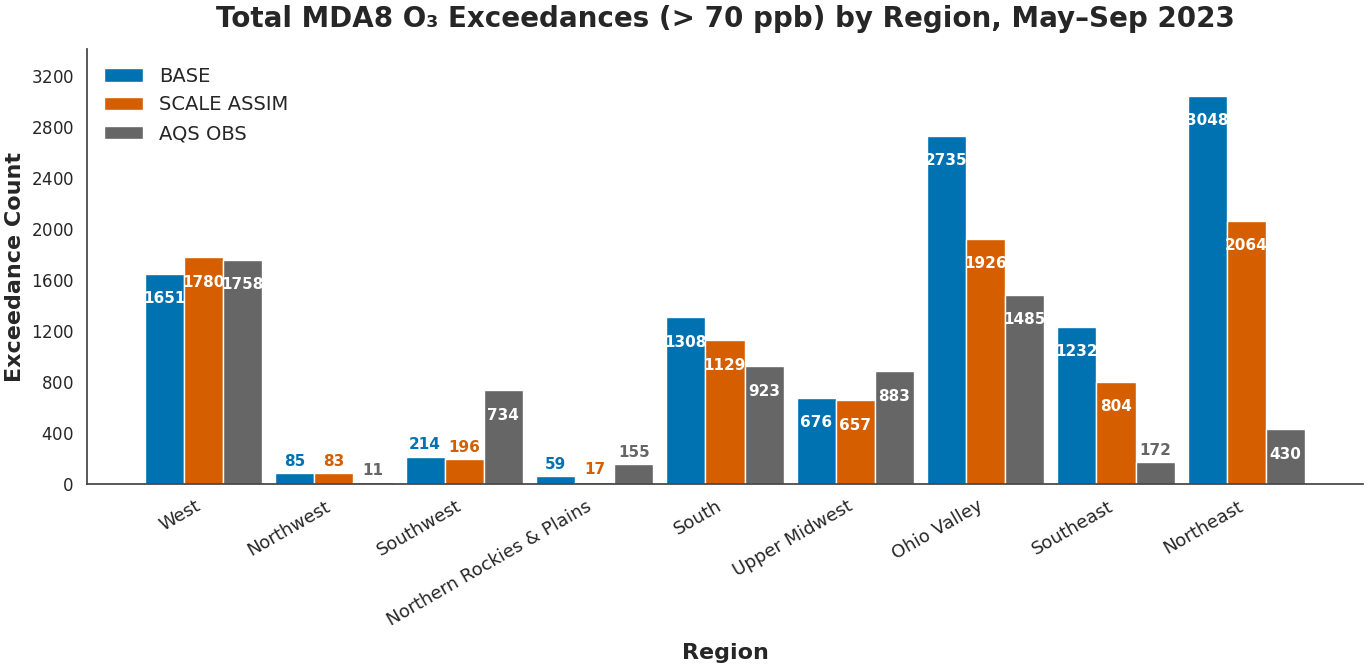

In [36]:
# Example: group by region
BDF_regions, CDF_regions = group_aqs_sites_by_region(BDF, CDF)
plot_exceedances_by_region_updated(BDF_regions, CDF_regions)

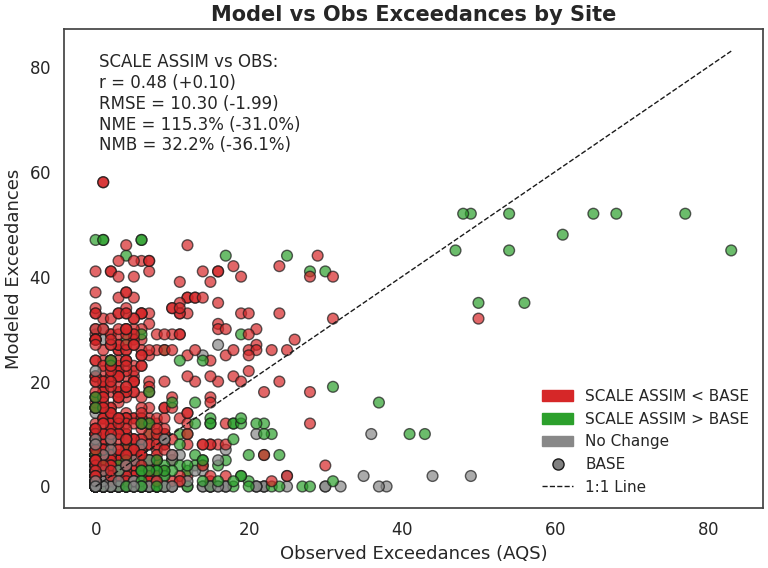

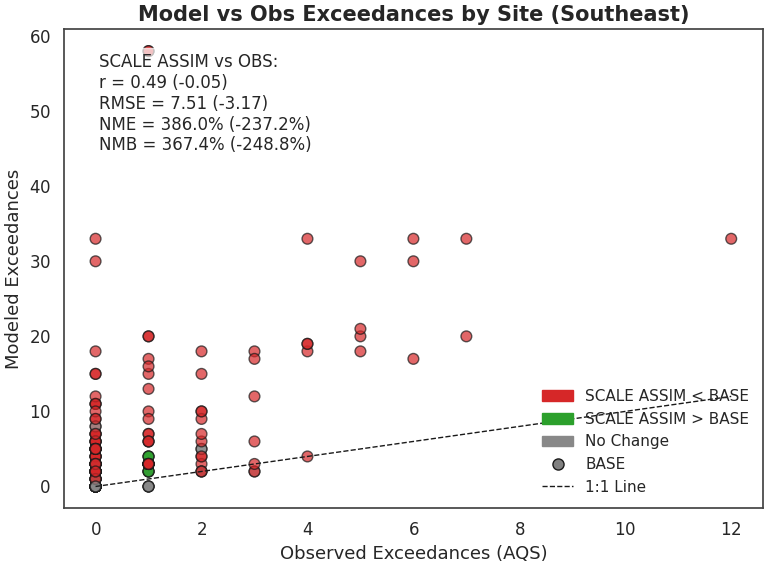

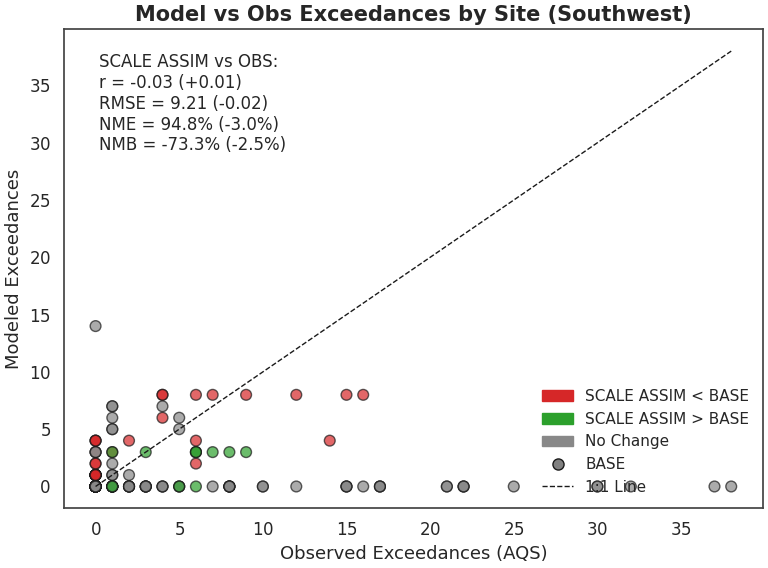

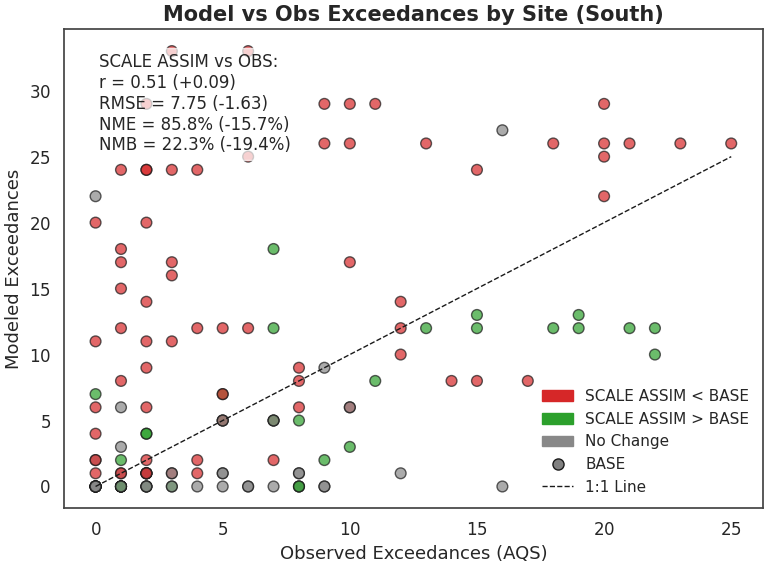

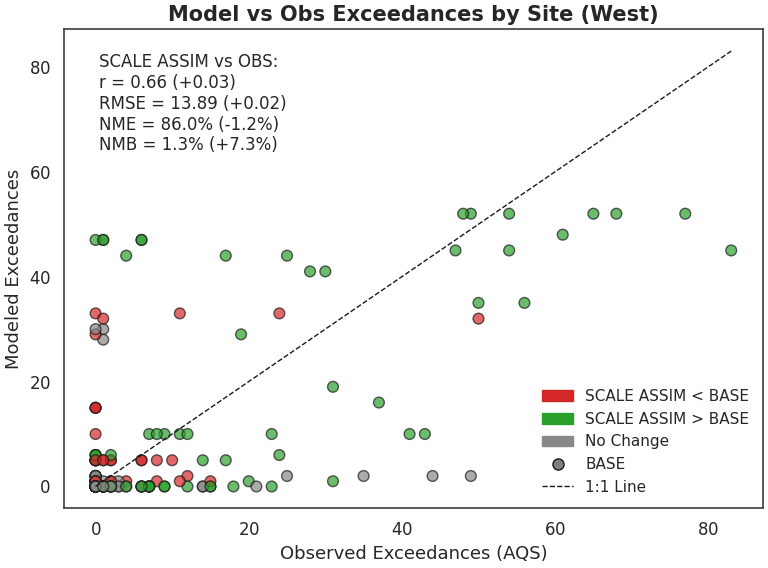

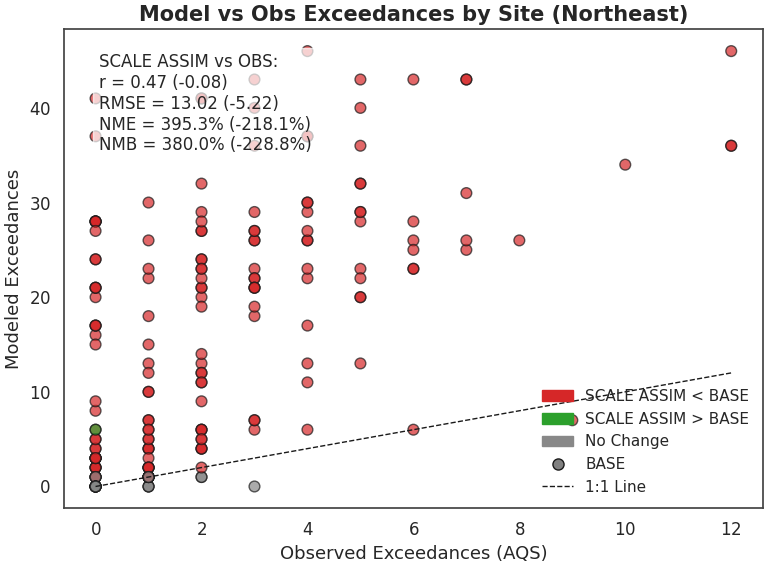

/home/jkumm/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jkumm/.local/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jkumm/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/jkumm/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jkumm/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


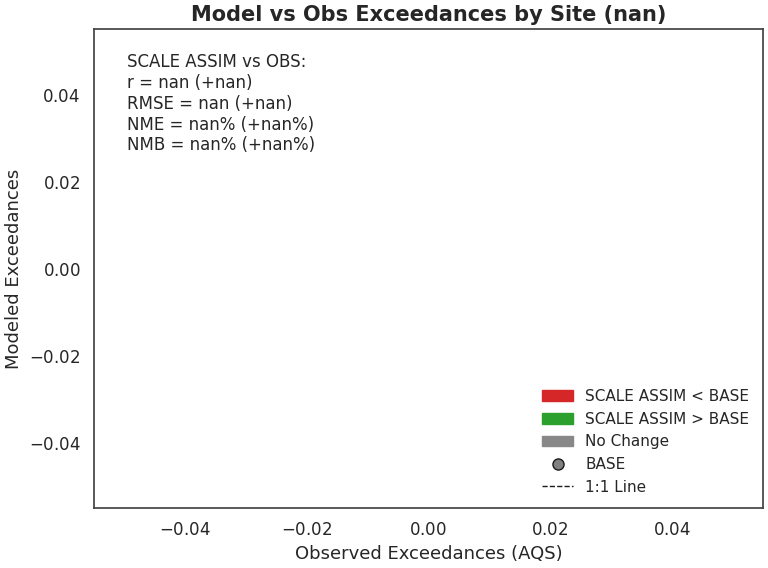

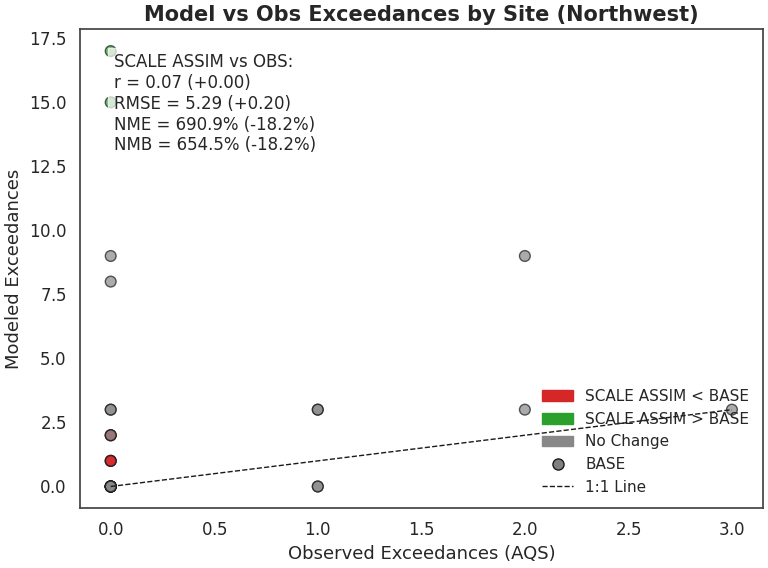

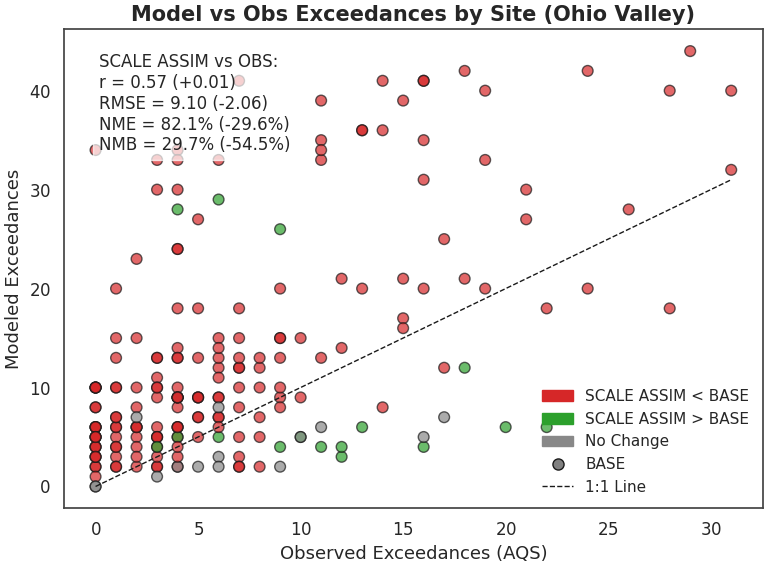

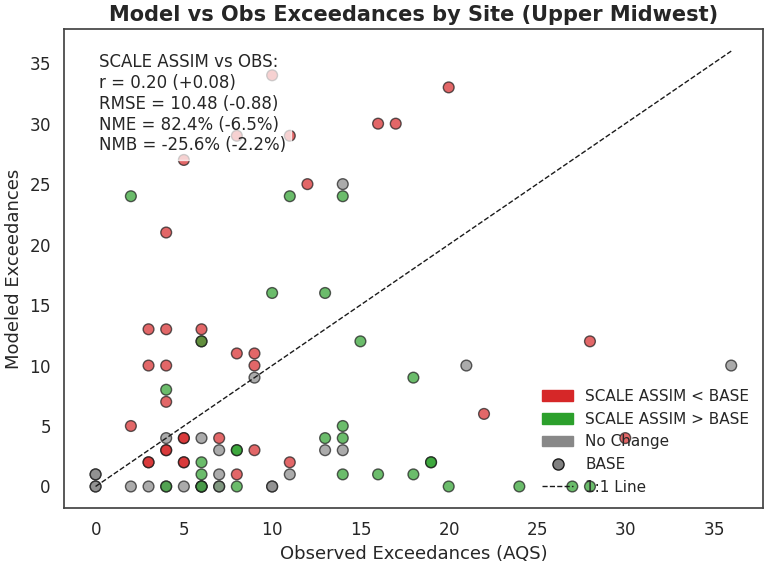

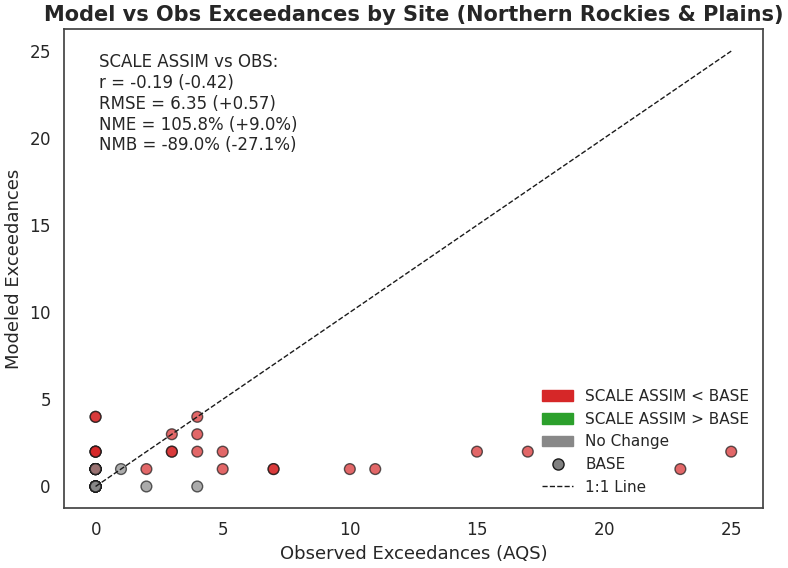

In [37]:
def scatterplot_exceedances_by_site_shaded(bdf, cdf, region=None, figsize=(8,6)):
    """
    Scatterplot of modeled vs observed AQS exceedances by SiteId for a region.
    BASE points are colored by SCALE ASSIM - BASE exceedance difference (red=decrease, green=increase).
    Annotates stats for SCALE ASSIM vs OBS, with difference from BASE vs OBS in parentheses.
    """
    # Filter by region if specified
    if region is not None:
        bdf = bdf[bdf['Region'] == region]
        cdf = cdf[cdf['Region'] == region]

    # Group by site for exceedance counts
    obs_exc = bdf.groupby('SiteId')['Exceedance_ob'].sum()
    base_exc = bdf.groupby('SiteId')['Exceedance_base'].sum()
    scale_exc = cdf.groupby('SiteId')['Exceedance_scale_assim'].sum()

    # Only keep sites with obs data
    df = pd.DataFrame({
        'OBS': obs_exc,
        'BASE': base_exc,
        'SCALE ASSIM': scale_exc
    }).dropna()

    # Calculate difference for shading
    diff = df['SCALE ASSIM'] - df['BASE']

    # Color map: red for decrease, green for increase, gray for no change
    colors = np.where(diff < 0, '#d62728', np.where(diff > 0, '#2ca02c', '#888888'))

    # Statistics
    def stats(obs, mod):
        r = np.corrcoef(obs, mod)[0,1]
        rmse = np.sqrt(np.mean((mod - obs)**2))
        nme = 100 * np.sum(np.abs(mod - obs)) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        nmb = 100 * np.sum(mod - obs) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        return r, rmse, nme, nmb

    # BASE vs OBS
    r_base, rmse_base, nme_base, nmb_base = stats(df['OBS'], df['BASE'])
    # SCALE ASSIM vs OBS
    r_scale, rmse_scale, nme_scale, nmb_scale = stats(df['OBS'], df['SCALE ASSIM'])

    # Differences
    dr = r_scale - r_base
    drmse = rmse_scale - rmse_base
    dnme = nme_scale - nme_base
    dnmb = nmb_scale - nmb_base

    # Scatterplot
    plt.figure(figsize=figsize)
    # BASE points colored by improvement
    plt.scatter(df['OBS'], df['BASE'], c=colors, alpha=0.7, edgecolor='k', label='BASE', s=60)
    plt.plot([df['OBS'].min(), df['OBS'].max()], [df['OBS'].min(), df['OBS'].max()], 'k--', lw=1, label='1:1 Line')
    plt.xlabel('Observed Exceedances (AQS)', fontsize=13)
    plt.ylabel('Modeled Exceedances', fontsize=13)
    title = f'Model vs Obs Exceedances by Site'
    if region:
        title += f' ({region})'
    plt.title(title, fontsize=15, weight='bold')

    # Annotate statistics for SCALE ASSIM vs OBS, with difference from BASE vs OBS
    stat_text = (
        f"SCALE ASSIM vs OBS:\n"
        f"r = {r_scale:.2f} ({dr:+.2f})\n"
        f"RMSE = {rmse_scale:.2f} ({drmse:+.2f})\n"
        f"NME = {nme_scale:.1f}% ({dnme:+.1f}%)\n"
        f"NMB = {nmb_scale:.1f}% ({dnmb:+.1f}%)"
    )
    plt.text(0.05, 0.95, stat_text, transform=plt.gca().transAxes,
             fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', alpha=0.7))

    # Legend
    import matplotlib.patches as mpatches
    legend_elements = [
        mpatches.Patch(color='#d62728', label='SCALE ASSIM < BASE'),
        mpatches.Patch(color='#2ca02c', label='SCALE ASSIM > BASE'),
        mpatches.Patch(color='#888888', label='No Change'),
        plt.Line2D([0], [0], marker='o', color='w', label='BASE', markerfacecolor='gray', markersize=8, markeredgecolor='k'),
        plt.Line2D([0], [0], color='k', lw=1, linestyle='--', label='1:1 Line')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=11)
    plt.tight_layout()
    plt.show()

# Overall plot
scatterplot_exceedances_by_site_shaded(BDF_regions, CDF_regions)

# By region
for region in BDF_regions['Region'].unique():
    scatterplot_exceedances_by_site_shaded(BDF_regions, CDF_regions, region=region)


In [38]:
def site_exceedance_table_national(bdf, cdf):
    # Count exceedances for BASE, SCALE ASSIM, and OBS at each site
    base_exc = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod'].apply(lambda x: (x > 70).sum())
    scale_exc = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod_scale_assim'].apply(lambda x: (x > 70).sum())
    obs_exc = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_ob'].apply(lambda x: (x > 70).sum())

    # Combine into a DataFrame
    df = pd.DataFrame({
        'BASE Exceedances': base_exc,
        'SCALE ASSIM Exceedances': scale_exc,
        'AQS OBS Exceedances': obs_exc
    }).reset_index()

    # Calculate change and departures
    df['Change (SCALE ASSIM - BASE)'] = df['SCALE ASSIM Exceedances'] - df['BASE Exceedances']
    df['BASE - OBS Departure'] = df['BASE Exceedances'] - df['AQS OBS Exceedances']
    df['SCALE ASSIM - OBS Departure'] = df['SCALE ASSIM Exceedances'] - df['AQS OBS Exceedances']

    return df

national_exceedance_table = site_exceedance_table_national(BDF_regions, CDF_regions)
national_exceedance_table.head(50)


SiteId  Latitude  Longitude  BASE Exceedances  SCALE ASSIM Exceedances  \
0   10030010    30.497    -87.880                11                        2   
1   10499991    34.289    -85.970                 4                        1   
2   10510004    32.536    -86.255                 4                        2   
3   10550011    33.904    -86.054                13                        5   
4   10730023    33.553    -86.815                20                       12   
5   10731003    33.486    -86.915                18                       12   
6   10731005    33.331    -87.004                18                       12   
7   10731010    33.545    -86.549                20                       12   
8   10735003    33.802    -86.942                 9                        5   
9   10736002    33.578    -86.774                20                       12   
10  10890014    34.685    -86.588                 3                        1   
11  10890022    34.773    -86.756                 3                        1   
12  10970003    30.770    -88.088                 6                        0   
13  10972005    30.474    -88.141                11                        2   
14  11011002    32.413    -86.263                 4                        2   
15  11030011    34.531    -86.968                 2                        2   
16  11130003    32.437    -85.000                 1                        0   
17  11170004    33.317    -86.826                20                       12   
18  11190003    32.363    -88.278                 0                        0   
19  11250011    33.095    -87.482                12                        4   
20  40038001    32.009   -109.390                 0                        0   
21  40051008    35.206   -111.650                 0                        0   
22  40058001    36.059   -112.180                 0                        0   
23  40070010    33.655   -111.110                 0                        0   
24  40128000    34.244   -113.560                 0                        0   
25  40130019    33.484   -112.140                 0                        0   
26  40131003    33.410   -111.870                 0                        0   
27  40131004    33.560   -112.070                 0                        0   
28  40131010    33.452   -111.730                 0                        0   
29  40132001    33.575   -112.190                 0                        0   
30  40132005    33.706   -111.860                 0                        0   
31  40133002    33.458   -112.050                 0                        0   
32  40133003    33.480   -111.920                 0                        0   
33  40134003    33.403   -112.080                 0                        0   
34  40134004    33.299   -111.880                 0                        0   
35  40134005    33.411   -111.930                 0                        0   
36  40134008    33.822   -112.020                 0                        0   
37  40134010    33.637   -112.340                 0                        0   
38  40134011    33.370   -112.620                 0                        0   
39  40135100    33.629   -111.680                 0                        0   
40  40137003    33.290   -112.160                 0                        0   
41  40137021    33.508   -111.760                 0                        0   
42  40137022    33.475   -111.810                 0                        0   
43  40137024    33.508   -111.840                 0                        0   
44  40139508    33.983   -111.800                 0                        0   
45  40139702    33.546   -111.610                 0                        0   
46  40139704    33.611   -111.730                 0                        0   
47  40139997    33.504   -112.100                 0                        0   
48  40170119    34.823   -109.890                 0                        0   
49  40

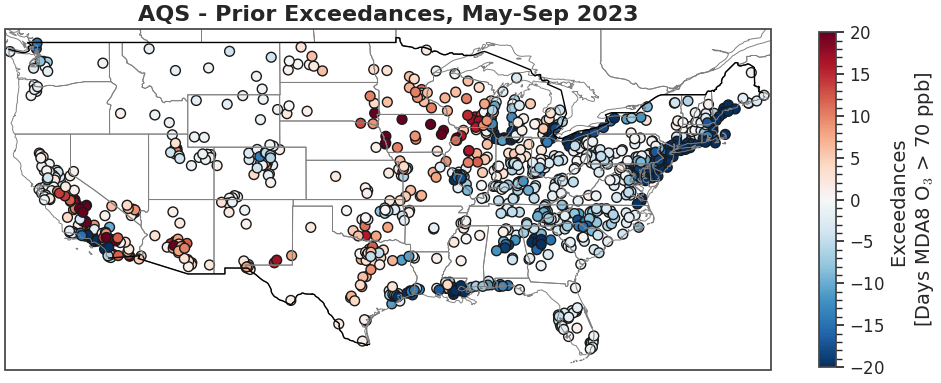

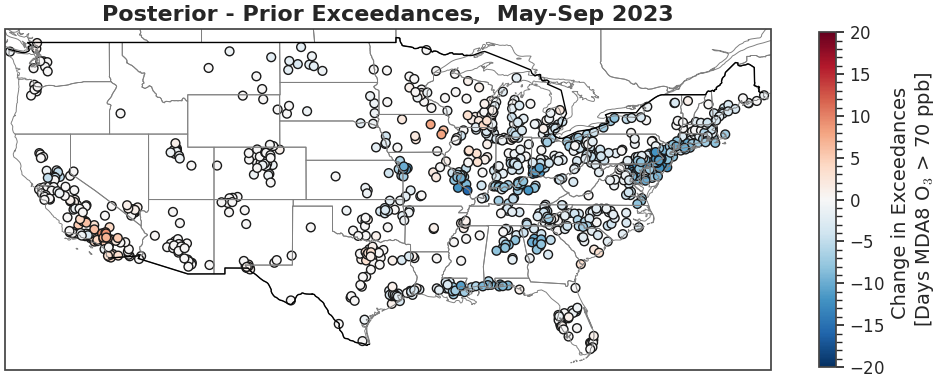

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# 1) AQS OBS vs BASE exceedances scatterplot (fade out sites with 0 obs and 0 base)
def plot_obs_vs_base_exceedances(national_exceedance_table):
    obs = national_exceedance_table['AQS OBS Exceedances']
    base = national_exceedance_table['BASE Exceedances']
    mask_nonzero = (obs > 0) | (base > 0)
    plt.figure(figsize=(8,6))
    # faded points (both zero)
    plt.scatter(obs[~mask_nonzero], base[~mask_nonzero], color='gray', alpha=0.15, label='Zero Exceedance Sites')
    # colored points (at least one nonzero)
    plt.scatter(obs[mask_nonzero], base[mask_nonzero], color='#0072B2', edgecolor='k', alpha=0.7, label='Active Sites')
    plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()], 'k--', lw=1, label='1:1 Line')
    plt.xlabel('AQS OBS Exceedances')
    plt.ylabel('BASE Exceedances')
    plt.title('AQS OBS vs BASE Exceedances by Site')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 2) BASE - OBS at each relevant site (only sites with nonzero obs or base)
def plot_base_minus_obs(national_exceedance_table):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import TwoSlopeNorm

    mask_relevant = (national_exceedance_table['AQS OBS Exceedances'] > 0) | (national_exceedance_table['BASE Exceedances'] > 0)
    df = national_exceedance_table[mask_relevant]
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
    sc = ax.scatter(
        df['Longitude'], df['Latitude'], 
        c=df['BASE - OBS Departure']*-1, cmap='RdBu_r', 
        s=50, edgecolor='k', 
        norm=TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20),
        transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='Exceedances \n[Days MDA8 O$_3$ > 70 ppb]', shrink=0.6)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('AQS - Prior Exceedances, May-Sep 2023')
    # Add US states and borders
    ax.add_feature(cfeature.STATES, linewidth=0.7, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

# 3) SCALE ASSIM - OBS at each relevant site
def plot_scale_assim_minus_obs(national_exceedance_table):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import TwoSlopeNorm

    mask_relevant = (national_exceedance_table['AQS OBS Exceedances'] > 0) | (national_exceedance_table['SCALE ASSIM Exceedances'] > 0)
    df = national_exceedance_table[mask_relevant]
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
    sc = ax.scatter(
        df['Longitude'], df['Latitude'], 
        c=df['SCALE ASSIM - OBS Departure'], cmap='RdBu_r', 
        s=40, edgecolor='k', 
        norm=TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20),
        transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='SCALE ASSIM - OBS Exceedances')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SCALE ASSIM - OBS Exceedance Difference by Site')
    # Add US states and borders
    ax.add_feature(cfeature.STATES, linewidth=0.7, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()
# 3) SCALE ASSIM - OBS at each relevant site
def plot_scale_assim_minus_base(national_exceedance_table):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import TwoSlopeNorm

    mask_relevant = (national_exceedance_table['AQS OBS Exceedances'] > 0) | (national_exceedance_table['SCALE ASSIM Exceedances'] > 0)
    df = national_exceedance_table[mask_relevant]
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
    sc = ax.scatter(
        df['Longitude'], df['Latitude'], 
        c=df['Change (SCALE ASSIM - BASE)'], cmap='RdBu_r', 
        s=40, edgecolor='k', 
        norm=TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20),
        transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='Change in Exceedances \n[Days MDA8 O$_3$ > 70 ppb]', shrink=0.6)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Posterior - Prior Exceedances,  May-Sep 2023')
    # Add US states and borders
    ax.add_feature(cfeature.STATES, linewidth=0.7, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

def plot_nme_change(national_exceedance_table):
    # Only sites with nonzero obs
    df = national_exceedance_table[national_exceedance_table['AQS OBS Exceedances'] > 0]
    obs = df['AQS OBS Exceedances']
    base = df['BASE Exceedances']
    scale = df['SCALE ASSIM Exceedances']
    nme_base = 100 * np.abs(base - obs) / obs
    nme_scale = 100 * np.abs(scale - obs) / obs
    nme_change = nme_scale - nme_base

    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.colors import TwoSlopeNorm

    # Use PlateCarree for scatter plot coordinates
    fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree()})
    sc = ax.scatter(df['Longitude'], df['Latitude'], c=nme_change, cmap='RdBu_r', s=20 + df['AQS OBS Exceedances']*4, edgecolor='k',
                    norm=TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100), transform=ccrs.PlateCarree())
    plt.colorbar(sc, ax=ax, label='ΔNME (SCALE ASSIM - BASE) [%]')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Change in NME (SCALE ASSIM - BASE) vs OBS by Site')

    # Add US states and borders
    ax.add_feature(cfeature.STATES, linewidth=0.7, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.set_extent([-125, -66.5, 24, 50], crs=ccrs.PlateCarree())

    plt.tight_layout()
    plt.show()

# Run all plots
# plot_obs_vs_base_exceedances(national_exceedance_table)
plot_base_minus_obs(national_exceedance_table)
# plot_scale_assim_minus_obs(national_exceedance_table)
plot_scale_assim_minus_base(national_exceedance_table)
# plot_nme_change(national_exceedance_table)

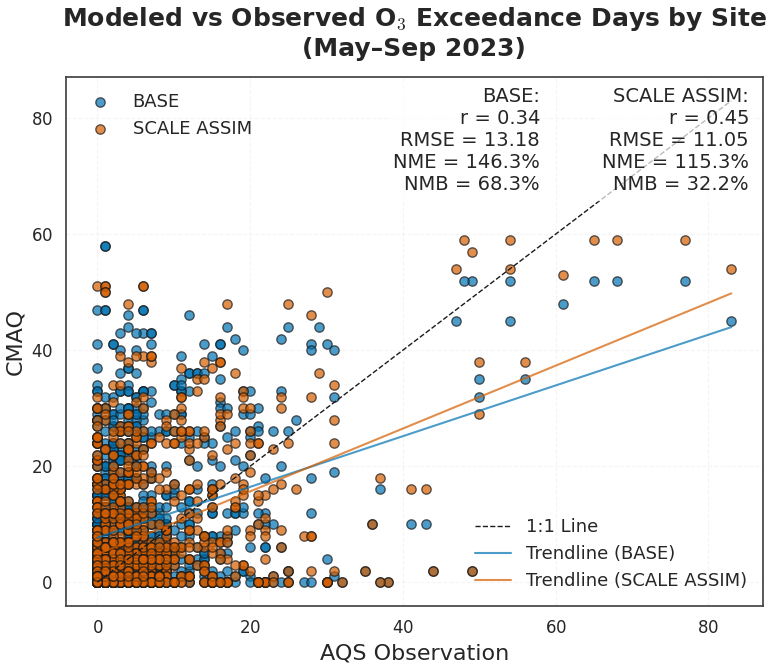

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def scatterplot_model_vs_obs_exceedances(national_exceedance_table, figsize=(8,7), savepath=None):
    """
    Publication-ready scatterplot of modeled vs observed exceedance counts by AQS site.
    Shows BASE and SCALE ASSIM as separate colors, with 1:1 line, trend lines, and key stats.
    """
    obs = national_exceedance_table['AQS OBS Exceedances']
    base = national_exceedance_table['BASE Exceedances']
    scale = national_exceedance_table['SCALE ASSIM Exceedances']

    # Only sites with at least one obs or model exceedance
    mask = (obs > 0) | (base > 0) | (scale > 0)
    obs, base, scale = obs[mask], base[mask], scale[mask]

    plt.figure(figsize=figsize)
    plt.grid(True, linestyle='--', alpha=0.3, zorder=0)
    # Scatter points
    plt.scatter(obs, base, c='#0072B2', alpha=0.7, edgecolor='k', s=45, label='BASE')
    plt.scatter(obs, scale, c='#D55E00', alpha=0.7, edgecolor='k', s=45, label='SCALE ASSIM')

    # 1:1 line
    minval = min(obs.min(), base.min(), scale.min())
    maxval = max(obs.max(), base.max(), scale.max())
    plt.plot([minval, maxval], [minval, maxval], 'k--', lw=1, label='1:1 Line')

    # Trend lines
    slope_base, intercept_base, r_base, _, _ = linregress(obs, base)
    slope_scale, intercept_scale, r_scale, _, _ = linregress(obs, scale)
    plt.plot([minval, maxval], [slope_base*minval+intercept_base, slope_base*maxval+intercept_base],
             color='#0072B2', lw=1.5, alpha=0.7, label=f'Trendline (BASE)')
    plt.plot([minval, maxval], [slope_scale*minval+intercept_scale, slope_scale*maxval+intercept_scale],
             color='#D55E00', lw=1.5, alpha=0.7, label=f'Trendline (SCALE ASSIM)')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    from matplotlib.legend import Legend
    plt.legend(handles[:2], labels[:2], loc='upper left', frameon=False, fontsize=13)
    plt.gca().add_artist(Legend(plt.gca(), handles[2:], labels[2:], loc='lower right', frameon=False, fontsize=13))
    
    # Stats
    def stat_text(obs, mod, label):
        rmse = np.sqrt(np.mean((mod - obs)**2))
        nme = 100 * np.sum(np.abs(mod - obs)) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        nmb = 100 * np.sum(mod - obs) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        return (f"{label}:\n"
                f"r = {np.corrcoef(obs, mod)[0,1]:.2f}\n"
                f"RMSE = {rmse:.2f}\n"
                f"NME = {nme:.1f}%\n"
                f"NMB = {nmb:.1f}%")

    stats_base = stat_text(obs, base, "BASE")
    stats_scale = stat_text(obs, scale, "SCALE ASSIM")
    plt.text(0.68, 0.98, stats_base, transform=plt.gca().transAxes, fontsize=14,
             va='top', ha='right', bbox=dict(facecolor='white', alpha=0.7))
    plt.text(0.98, 0.98, stats_scale, transform=plt.gca().transAxes, fontsize=14,
             va='top', ha='right', bbox=dict(facecolor='white', alpha=0.7))

    plt.xlabel('AQS Observation', fontsize=16)
    plt.ylabel('CMAQ', fontsize=16)
    plt.title('Modeled vs Observed O$_3$ Exceedance Days by Site\n(May–Sep 2023)', fontsize=18, weight='bold', pad=15)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight')
        plt.savefig(savepath.replace('.png', '.pdf'), dpi=400, bbox_inches='tight')
    plt.show()

# Usage:
scatterplot_model_vs_obs_exceedances(national_exceedance_table, savepath='Model_vs_Obs_Exceedances_Scatter.png')

In [41]:
national_exceedance_table.to_csv('national_exceedance_table.csv', index=False)

In [42]:
# Add region classification to national_exceedance_table using BDF_regions mapping
site_region_map = BDF_regions.drop_duplicates(subset='SiteId').set_index('SiteId')['Region']
national_exceedance_table['Region'] = national_exceedance_table['SiteId'].map(site_region_map)

In [43]:
national_exceedance_table.to_csv('national_exceedance_table.csv', index=False)

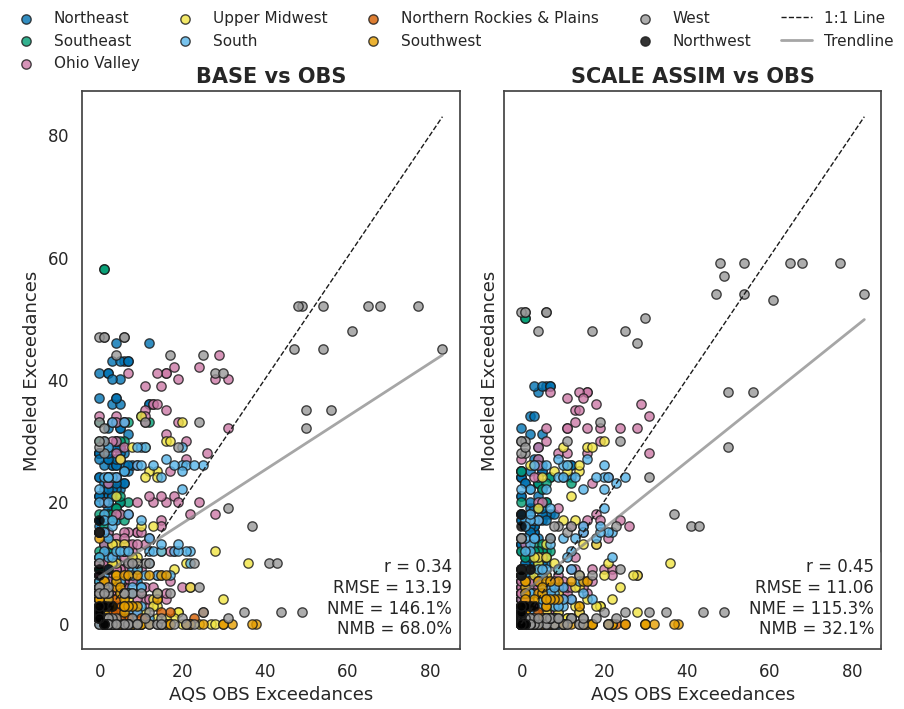

In [44]:
import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt

def scatterplot_exceedances_by_region(national_exceedance_table, figsize=(9,7), savepath=None):
    """
    Scatterplot of modeled vs observed exceedances by site, colored by region.
    Plots both BASE vs OBS and SCALE ASSIM vs OBS.
    Includes 1:1 line and trendlines.
    """
    # Only sites with at least one obs or model exceedance and a region assigned
    df = national_exceedance_table.dropna(subset=['Region'])
    mask = (df['AQS OBS Exceedances'] > 0) | (df['BASE Exceedances'] > 0) | (df['SCALE ASSIM Exceedances'] > 0)
    df = df[mask]

    # Define region color palette (colorblind-friendly)
    region_palette = {
        "Northeast": "#0072B2",
        "Southeast": "#009E73",
        "Ohio Valley": "#CC79A7",
        "Upper Midwest": "#F0E442",
        "South": "#56B4E9",
        "Northern Rockies & Plains": "#D55E00",
        "Southwest": "#E69F00",
        "West": "#999999",
        "Northwest": "#000000"
    }
    # Assign colors
    df['color'] = df['Region'].map(region_palette).fillna('#888888')

    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True, sharey=True)
    for ax, model_col, title in zip(
        axes,
        ['BASE Exceedances', 'SCALE ASSIM Exceedances'],
        ['BASE vs OBS', 'SCALE ASSIM vs OBS']
    ):
        obs = df['AQS OBS Exceedances']
        mod = df[model_col]
        colors = df['color']

        # Scatter
        for region, color in region_palette.items():
            region_mask = df['Region'] == region
            ax.scatter(
                obs[region_mask], mod[region_mask],
                c=color, label=region, edgecolor='k', s=45, alpha=0.8
            )

        # 1:1 line
        minval = min(obs.min(), mod.min())
        maxval = max(obs.max(), mod.max())
        ax.plot([minval, maxval], [minval, maxval], 'k--', lw=1, label='1:1 Line')

        # Trendline
        slope, intercept, r, _, _ = linregress(obs, mod)
        ax.plot([minval, maxval], [slope*minval+intercept, slope*maxval+intercept],
                color='gray', lw=2, alpha=0.7, label='Trendline')

        # Stats annotation
        rmse = np.sqrt(np.mean((mod - obs)**2))
        nme = 100 * np.sum(np.abs(mod - obs)) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        nmb = 100 * np.sum(mod - obs) / np.sum(obs) if np.sum(obs) != 0 else np.nan
        stat_text = (
            f"r = {r:.2f}\n"
            f"RMSE = {rmse:.2f}\n"
            f"NME = {nme:.1f}%\n"
            f"NMB = {nmb:.1f}%"
        )
        ax.text(0.98, 0.02, stat_text, transform=ax.transAxes, fontsize=12,
                va='bottom', ha='right', bbox=dict(facecolor='white', alpha=0.7))

        ax.set_title(title, fontsize=15, weight='bold')
        ax.set_xlabel('AQS OBS Exceedances', fontsize=13)
        ax.set_ylabel('Modeled Exceedances', fontsize=13)

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=5, frameon=False, fontsize=11, bbox_to_anchor=(0.5, 1.04))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if savepath:
        plt.savefig(savepath, dpi=400, bbox_inches='tight')
        plt.savefig(savepath.replace('.png', '.pdf'), dpi=400, bbox_inches='tight')
    plt.show()

scatterplot_exceedances_by_region(national_exceedance_table)

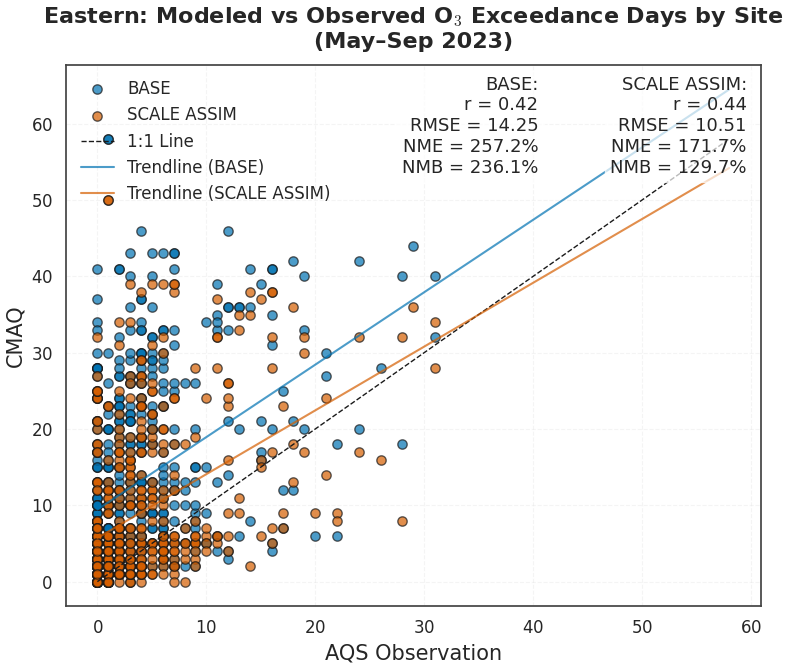

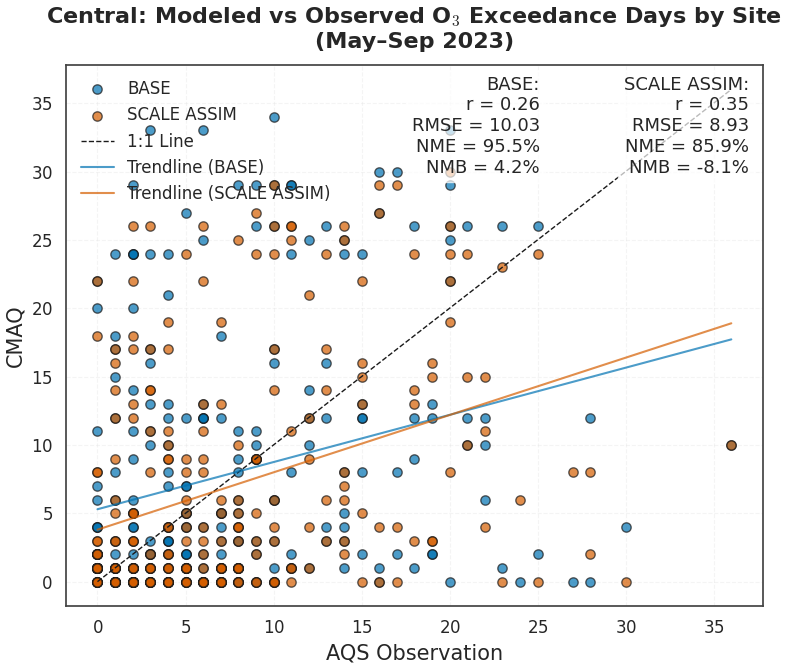

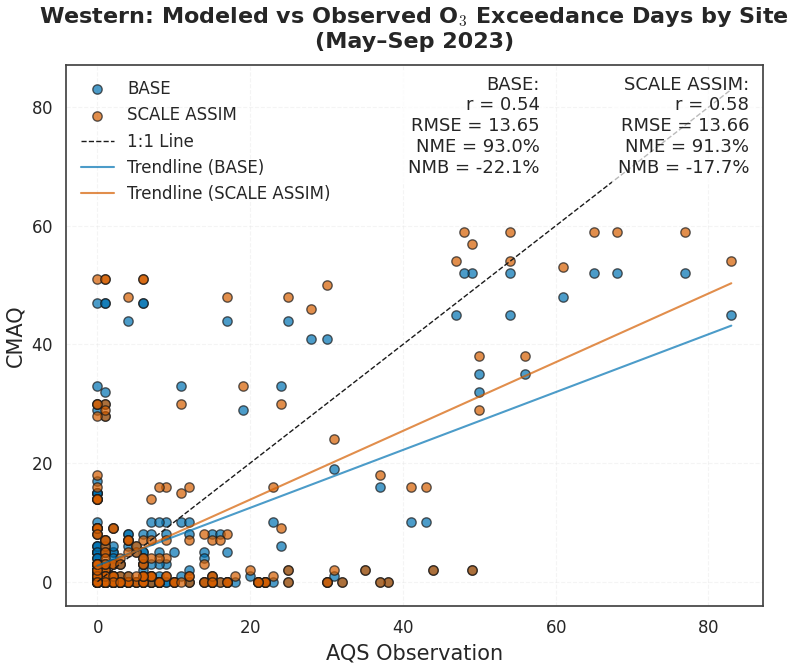

In [45]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def scatterplot_exceedances_by_superregion(national_exceedance_table, figsize=(8,7), savepath_prefix=None):
    """
    Publication-ready scatterplots of modeled vs observed exceedance counts by AQS site,
    split into three super-regions: Eastern, Central, Western.
    Each plot shows BASE and SCALE ASSIM as separate colors, with 1:1 line, trend lines, and key stats.
    """
    # Define super-regions
    superregions = {
        "Eastern": ['Northeast', 'Southeast', 'Ohio Valley'],
        "Central": ['Upper Midwest', 'South', 'Northern Rockies & Plains'],
        "Western": ['West', 'Northwest', 'Southwest'],
    }
    region_palette = {
        "Northeast": "#0072B2",
        "Southeast": "#009E73",
        "Ohio Valley": "#CC79A7",
        "Upper Midwest": "#F0E442",
        "South": "#56B4E9",
        "Northern Rockies & Plains": "#D55E00",
        "Southwest": "#E69F00",
        "West": "#999999",
        "Northwest": "#000000"
    }
    for superregion, region_list in superregions.items():
        df = national_exceedance_table[national_exceedance_table['Region'].isin(region_list)].dropna(subset=['Region'])
        mask = (df['AQS OBS Exceedances'] > 0) | (df['BASE Exceedances'] > 0) | (df['SCALE ASSIM Exceedances'] > 0)
        df = df[mask]
        obs = df['AQS OBS Exceedances']
        base = df['BASE Exceedances']
        scale = df['SCALE ASSIM Exceedances']
        # --- Plot ---
        plt.figure(figsize=figsize)
        plt.grid(True, linestyle='--', alpha=0.3, zorder=0)
        # BASE
        plt.scatter(obs, base, c='#0072B2', alpha=0.7, edgecolor='k', s=45, label='BASE')
        # SCALE ASSIM
        plt.scatter(obs, scale, c='#D55E00', alpha=0.7, edgecolor='k', s=45, label='SCALE ASSIM')
        # 1:1 line
        minval = min(obs.min(), base.min(), scale.min())
        maxval = max(obs.max(), base.max(), scale.max())
        plt.plot([minval, maxval], [minval, maxval], 'k--', lw=1, label='1:1 Line')
        # Trend lines
        if len(obs) > 1:
            slope_base, intercept_base, r_base, _, _ = linregress(obs, base)
            slope_scale, intercept_scale, r_scale, _, _ = linregress(obs, scale)
            plt.plot([minval, maxval], [slope_base*minval+intercept_base, slope_base*maxval+intercept_base],
                     color='#0072B2', lw=1.5, alpha=0.7, label='Trendline (BASE)')
            plt.plot([minval, maxval], [slope_scale*minval+intercept_scale, slope_scale*maxval+intercept_scale],
                     color='#D55E00', lw=1.5, alpha=0.7, label='Trendline (SCALE ASSIM)')
        # Stats
        def stat_text(obs, mod, label):
            rmse = np.sqrt(np.mean((mod - obs)**2))
            nme = 100 * np.sum(np.abs(mod - obs)) / np.sum(obs) if np.sum(obs) != 0 else np.nan
            nmb = 100 * np.sum(mod - obs) / np.sum(obs) if np.sum(obs) != 0 else np.nan
            r = np.corrcoef(obs, mod)[0,1] if len(obs) > 1 else np.nan
            return (f"{label}:\n"
                    f"r = {r:.2f}\n"
                    f"RMSE = {rmse:.2f}\n"
                    f"NME = {nme:.1f}%\n"
                    f"NMB = {nmb:.1f}%")
        stats_base = stat_text(obs, base, "BASE")
        stats_scale = stat_text(obs, scale, "SCALE ASSIM")
        plt.text(0.68, 0.98, stats_base, transform=plt.gca().transAxes, fontsize=13,
                 va='top', ha='right', bbox=dict(facecolor='white', alpha=0.7))
        plt.text(0.98, 0.98, stats_scale, transform=plt.gca().transAxes, fontsize=13,
                 va='top', ha='right', bbox=dict(facecolor='white', alpha=0.7))
        plt.xlabel('AQS Observation', fontsize=15)
        plt.ylabel('CMAQ', fontsize=15)
        plt.title(f'{superregion}: Modeled vs Observed O$_3$ Exceedance Days by Site\n(May–Sep 2023)', fontsize=16, weight='bold', pad=12)
        plt.legend(loc='upper left', frameon=False, fontsize=12)
        plt.tight_layout()
        if savepath_prefix:
            plt.savefig(f"{savepath_prefix}_{superregion}.png", dpi=400, bbox_inches='tight')
            plt.savefig(f"{savepath_prefix}_{superregion}.pdf", dpi=400, bbox_inches='tight')
        plt.show()

# Usage:
scatterplot_exceedances_by_superregion(national_exceedance_table, savepath_prefix='Model_vs_Obs_Exceedances_Scatter_BySuperregion')

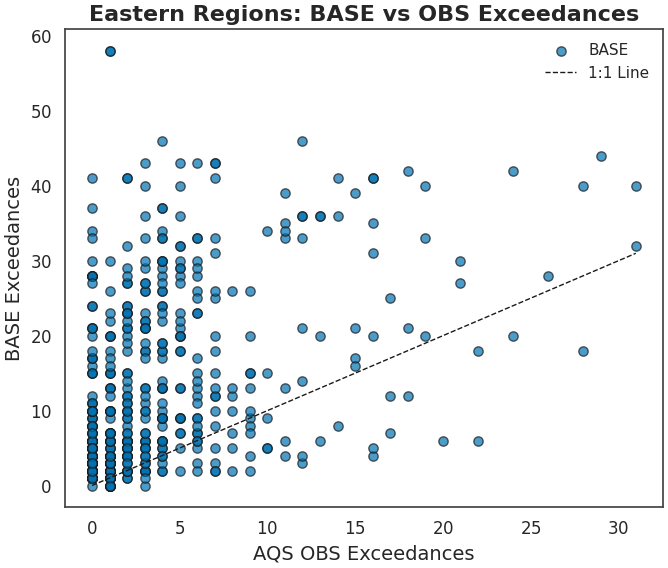

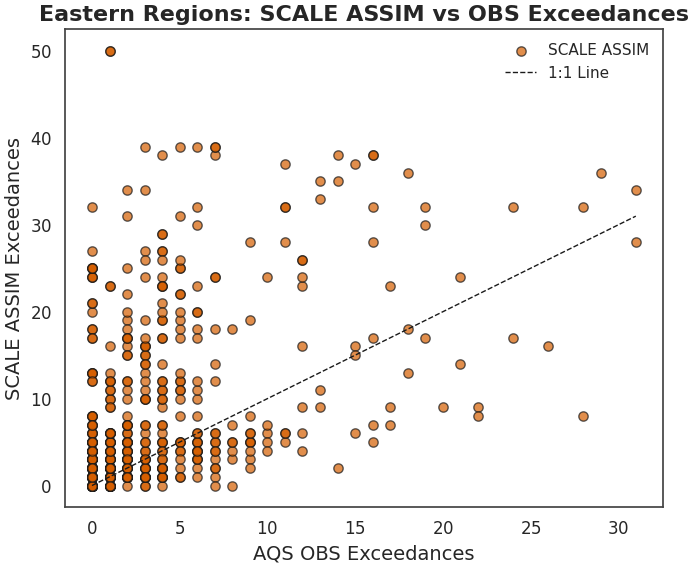

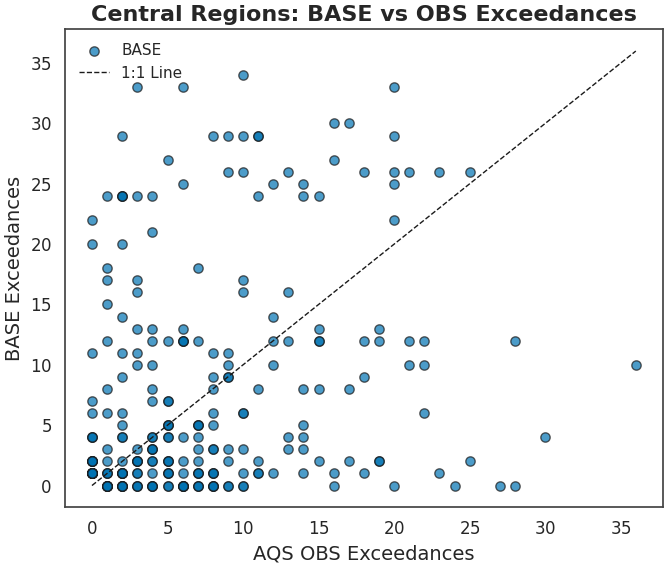

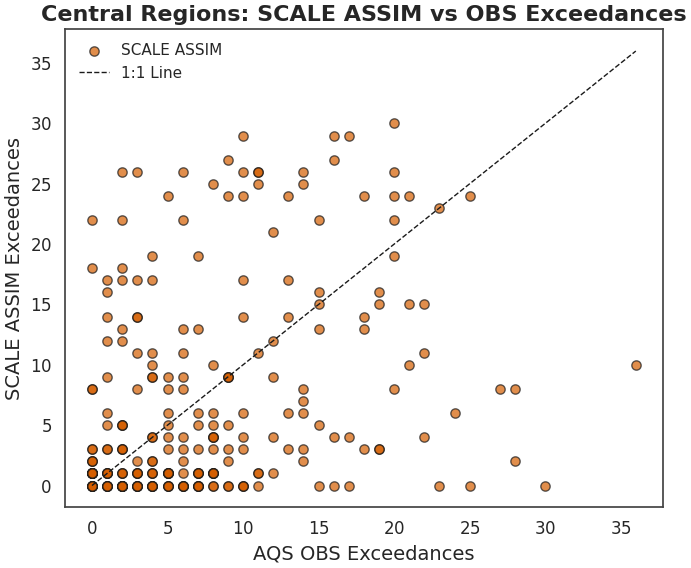

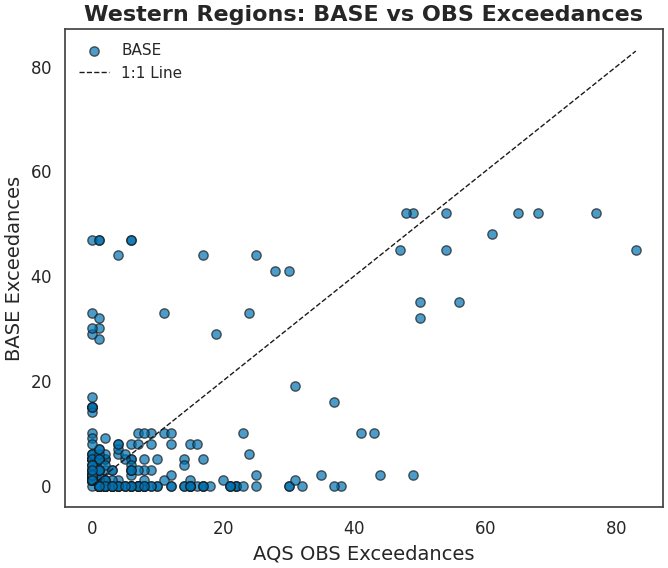

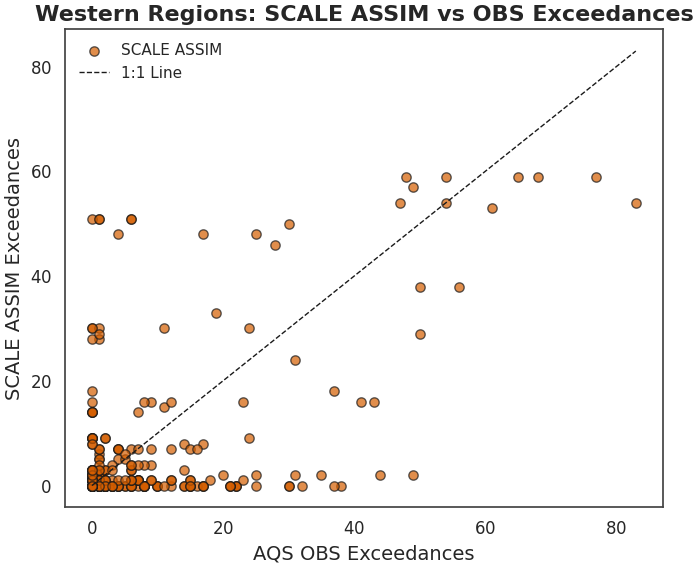

In [46]:
# Define region groups
eastern_regions = ['Northeast', 'Southeast', 'Ohio Valley']
central_regions = ['Upper Midwest', 'Northern Rockies & Plains', 'South']
western_regions = ['Northwest', 'West', 'Southwest']

# Helper to filter and plot
def plot_region_exceedance_pairs(region_list, region_label):
    df = national_exceedance_table[national_exceedance_table['Region'].isin(region_list)]
    # Only sites with at least one obs or model exceedance
    mask = (df['AQS OBS Exceedances'] > 0) | (df['BASE Exceedances'] > 0) | (df['SCALE ASSIM Exceedances'] > 0)
    df = df[mask]
    obs = df['AQS OBS Exceedances']
    base = df['BASE Exceedances']
    scale = df['SCALE ASSIM Exceedances']

    # Scatterplot BASE vs OBS
    plt.figure(figsize=(7,6))
    plt.scatter(obs, base, c='#0072B2', edgecolor='k', s=45, alpha=0.7, label='BASE')
    plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()], 'k--', lw=1, label='1:1 Line')
    plt.xlabel('AQS OBS Exceedances')
    plt.ylabel('BASE Exceedances')
    plt.title(f'{region_label}: BASE vs OBS Exceedances')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Scatterplot SCALE ASSIM vs OBS
    plt.figure(figsize=(7,6))
    plt.scatter(obs, scale, c='#D55E00', edgecolor='k', s=45, alpha=0.7, label='SCALE ASSIM')
    plt.plot([obs.min(), obs.max()], [obs.min(), obs.max()], 'k--', lw=1, label='1:1 Line')
    plt.xlabel('AQS OBS Exceedances')
    plt.ylabel('SCALE ASSIM Exceedances')
    plt.title(f'{region_label}: SCALE ASSIM vs OBS Exceedances')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eastern
plot_region_exceedance_pairs(eastern_regions, 'Eastern Regions')
# Central
plot_region_exceedance_pairs(central_regions, 'Central Regions')
# Western
plot_region_exceedance_pairs(western_regions, 'Western Regions')

In [47]:
# Filter for Southwest region
sw_bdf = BDF_regions[BDF_regions['Region'] == 'Southwest']
sw_cdf = CDF_regions[CDF_regions['Region'] == 'Southwest']

# Group by SiteId, Latitude, Longitude for unique sites
def site_exceedance_table(bdf, cdf):
    # Count exceedances for BASE, SCALE ASSIM, and OBS
    base_exc = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod'].apply(lambda x: (x > 70).sum())
    scale_exc = cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod_scale_assim'].apply(lambda x: (x > 70).sum())
    obs_exc = bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_ob'].apply(lambda x: (x > 70).sum())

    # Combine into a DataFrame
    df = pd.DataFrame({
        'BASE Exceedances': base_exc,
        'SCALE ASSIM Exceedances': scale_exc,
        'AQS OBS Exceedances': obs_exc
    }).reset_index()

    # Calculate change and departures
    df['Change (SCALE ASSIM - BASE)'] = df['SCALE ASSIM Exceedances'] - df['BASE Exceedances']
    df['BASE - OBS Departure'] = df['BASE Exceedances'] - df['AQS OBS Exceedances']
    df['SCALE ASSIM - OBS Departure'] = df['SCALE ASSIM Exceedances'] - df['AQS OBS Exceedances']

    return df

sw_exceedance_table = site_exceedance_table(sw_bdf, sw_cdf)
sw_exceedance_table.head(50)  # Display first 20 rows

SiteId  Latitude  Longitude  BASE Exceedances  SCALE ASSIM Exceedances  \
0   40038001    32.009    -109.39                 0                        0   
1   40051008    35.206    -111.65                 0                        0   
2   40058001    36.059    -112.18                 0                        0   
3   40070010    33.655    -111.11                 0                        0   
4   40128000    34.244    -113.56                 0                        0   
5   40130019    33.484    -112.14                 0                        0   
6   40131003    33.410    -111.87                 0                        0   
7   40131004    33.560    -112.07                 0                        0   
8   40131010    33.452    -111.73                 0                        0   
9   40132001    33.575    -112.19                 0                        0   
10  40132005    33.706    -111.86                 0                        0   
11  40133002    33.458    -112.05                 0                        0   
12  40133003    33.480    -111.92                 0                        0   
13  40134003    33.403    -112.08                 0                        0   
14  40134004    33.299    -111.88                 0                        0   
15  40134005    33.411    -111.93                 0                        0   
16  40134008    33.822    -112.02                 0                        0   
17  40134010    33.637    -112.34                 0                        0   
18  40134011    33.370    -112.62                 0                        0   
19  40135100    33.629    -111.68                 0                        0   
20  40137003    33.290    -112.16                 0                        0   
21  40137021    33.508    -111.76                 0                        0   
22  40137022    33.475    -111.81                 0                        0   
23  40137024    33.508    -111.84                 0                        0   
24  40139508    33.983    -111.80                 0                        0   
25  40139702    33.546    -111.61                 0                        0   
26  40139704    33.611    -111.73                 0                        0   
27  40139997    33.504    -112.10                 0                        0   
28  40170119    34.823    -109.89                 0                        0   
29  40190021    32.175    -110.74                 0                        0   
30  40191011    32.204    -110.88                 0                        0   
31  40191018    32.425    -111.06                 0                        0   
32  40191020    32.048    -110.77                 0                        0   
33  40191028    32.295    -110.98                 0                        0   
34  40191030    31.880    -111.00                 0                        0   
35  40191032    32.173    -110.98                 0                        0   
36  40191034    32.381    -111.13                 0                        0   
37  40213001    33.421    -111.54                 0                        0   
38  40213003    32.954    -111.76                 0                        0   
39  40213007    32.508    -111.31                 0                        0   
40  40217001    33.082    -111.75                 0                        0   
41  40218001    33.293    -111.29                 0                        0   
42  40258034    34.612    -112.46                 0                        0   
43  40278011    32.690    -114.61                 0                        0   
44  80013001    39.838    -104.95                 8                        7   
45  80050002    39.568    -104.96                 8                        7   
46  80050006    39.639    -104.57                 6                        5   
47  80077004    37.206    -107.25                 1                        1   
48  80130014    40.070    -105.22                 7                        7   
49  80

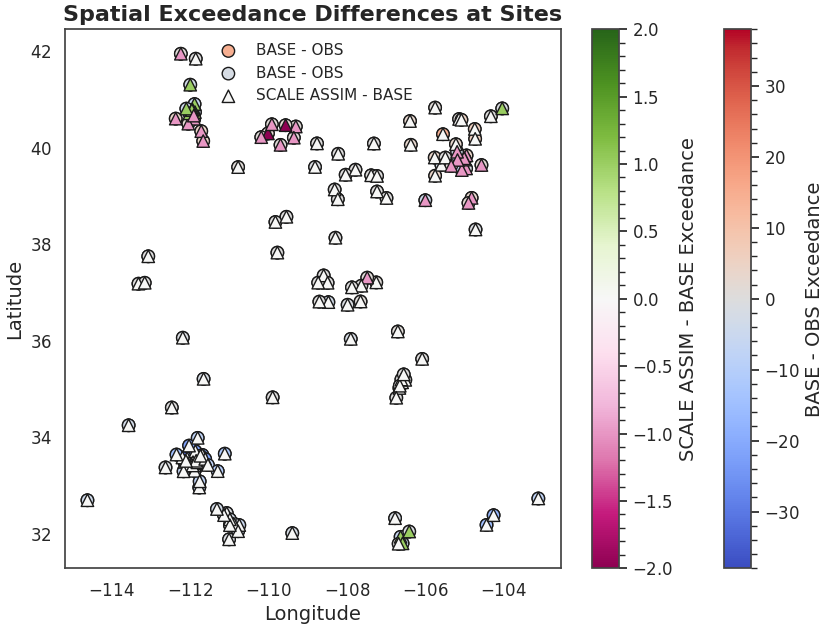

In [48]:
import matplotlib.pyplot as plt

def plot_sw_exceedance_diffs(sw_exceedance_table, site_lat_col='Latitude', site_lon_col='Longitude'):
    """
    Plots spatial differences for each site:
    - SCALE ASSIM - BASE (model improvement)
    - BASE - AQS OBS (model bias)
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    # Plot BASE - AQS OBS (model bias) as circles
    sc1 = ax.scatter(
        sw_exceedance_table[site_lon_col], sw_exceedance_table[site_lat_col],
        c=sw_exceedance_table['BASE Exceedances'] - sw_exceedance_table['AQS OBS Exceedances'],
        cmap='coolwarm', s=80, marker='o', edgecolor='k', label='BASE - OBS'
    )
    # Plot SCALE ASSIM - BASE as triangles
    # Calculate limits for diverging colorbars
    base_obs_diff = sw_exceedance_table['BASE Exceedances'] - sw_exceedance_table['AQS OBS Exceedances']
    obs = sw_exceedance_table['AQS OBS Exceedances']
    scale_base_diff = sw_exceedance_table['SCALE ASSIM Exceedances'] - sw_exceedance_table['BASE Exceedances']
    vlim1 = max(abs(base_obs_diff.min()), abs(base_obs_diff.max()))
    vlim2 = max(abs(scale_base_diff.min()), abs(scale_base_diff.max()))

    # BASE - OBS (model bias)
    sc1 = ax.scatter(
        sw_exceedance_table[site_lon_col], sw_exceedance_table[site_lat_col],
        c=base_obs_diff,
        cmap='coolwarm', s=80, marker='o', edgecolor='k', label='BASE - OBS',
        vmin=-vlim1, vmax=vlim1
    )
    # SCALE ASSIM - BASE (model improvement)
    sc2 = ax.scatter(
        sw_exceedance_table[site_lon_col], sw_exceedance_table[site_lat_col],
        c=scale_base_diff,
        cmap='PiYG', s=80, marker='^', edgecolor='k', label='SCALE ASSIM - BASE',
        vmin=-vlim2, vmax=vlim2
    )


# Set map extent
    plt.colorbar(sc1, ax=ax, label='BASE - OBS Exceedance')
    plt.colorbar(sc2, ax=ax, label='SCALE ASSIM - BASE Exceedance')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Spatial Exceedance Differences at Sites')
    ax.legend()
    plt.show()

# Usage:
plot_sw_exceedance_diffs(sw_exceedance_table)

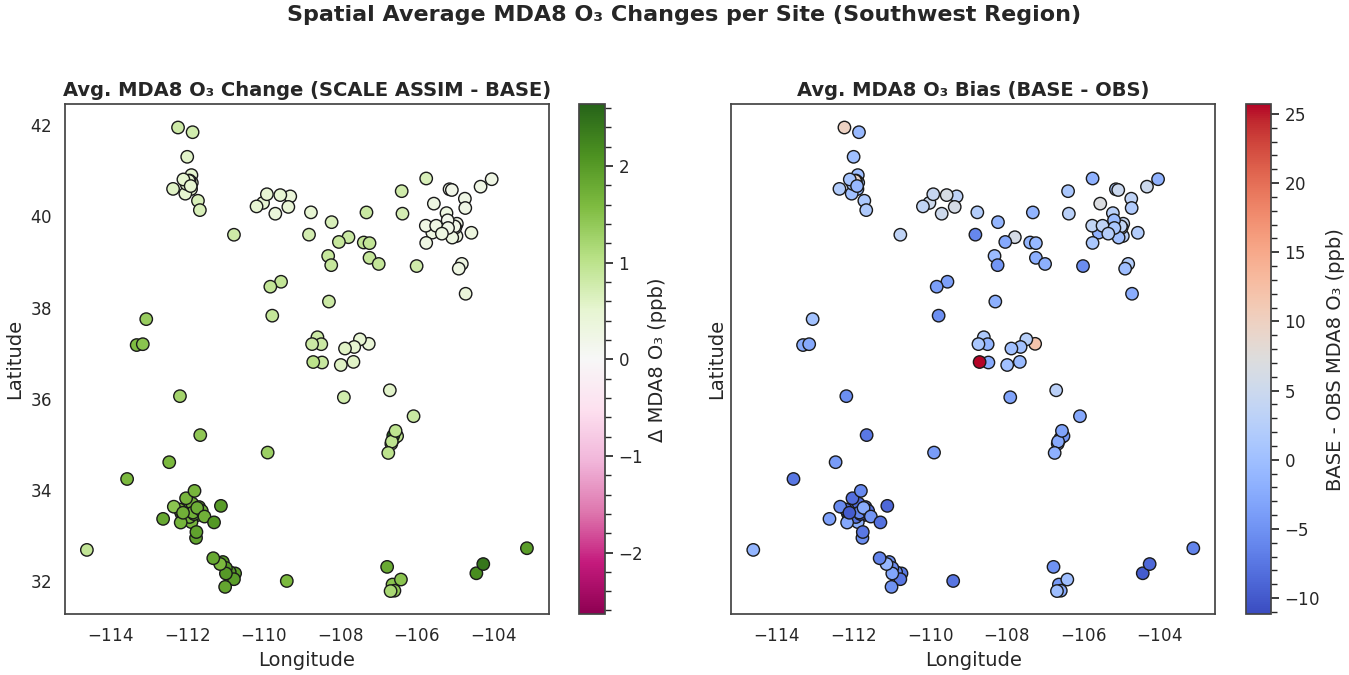

In [49]:
import matplotlib.pyplot as plt

def plot_sw_mda8_changes(sw_exceedance_table, sw_bdf, sw_cdf):
    """
    Plots spatial maps for Southwest region:
    - Average modeled MDA8 O3 change per site (SCALE ASSIM - BASE)
    - BASE - OBS difference per site

    Parameters:
        sw_exceedance_table (pd.DataFrame): Table with site info and exceedance counts.
        sw_bdf (pd.DataFrame): Southwest region DataFrame with daily O3 values.
    """
    # Compute average MDA8 O3 per site for BASE, SCALE ASSIM, and OBS
    base_mean = sw_bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod'].mean().reset_index(name='BASE_MDA8')
    scale_mean = sw_cdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_mod_scale_assim'].mean().reset_index(name='SCALE_ASSIM_MDA8')
    obs_mean = sw_bdf.groupby(['SiteId', 'Latitude', 'Longitude'])['O3_8hrmax_9cell_ob'].mean().reset_index(name='OBS_MDA8')

    # Merge means into one DataFrame
    merged = base_mean.merge(scale_mean, on=['SiteId', 'Latitude', 'Longitude'])
    merged = merged.merge(obs_mean, on=['SiteId', 'Latitude', 'Longitude'])

    # Calculate changes
    merged['SCALE_ASSIM_minus_BASE'] = merged['SCALE_ASSIM_MDA8'] - merged['BASE_MDA8']
    merged['BASE_minus_OBS'] = merged['BASE_MDA8'] - merged['OBS_MDA8']

    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)

    # Panel 1: SCALE ASSIM - BASE (model improvement)
    # Panel 1: SCALE ASSIM - BASE (model improvement), centered at 0
    vlim = max(abs(merged['SCALE_ASSIM_minus_BASE'].min()), abs(merged['SCALE_ASSIM_minus_BASE'].max()))
    sc1 = axes[0].scatter(
        merged['Longitude'], merged['Latitude'],
        c=merged['SCALE_ASSIM_minus_BASE'],
        cmap='PiYG', s=80, edgecolor='k', vmin=-vlim, vmax=vlim
    )
    axes[0].set_title('Avg. MDA8 O₃ Change (SCALE ASSIM - BASE)', fontsize=14)
    plt.colorbar(sc1, ax=axes[0], label='Δ MDA8 O₃ (ppb)')

    # Panel 2: BASE - OBS (model bias)
    sc2 = axes[1].scatter(
        merged['Longitude'], merged['Latitude'],
        c=merged['BASE_minus_OBS'],
        cmap='coolwarm', s=80, edgecolor='k'
    )
    axes[1].set_title('Avg. MDA8 O₃ Bias (BASE - OBS)', fontsize=14)
    plt.colorbar(sc2, ax=axes[1], label='BASE - OBS MDA8 O₃ (ppb)')

    for ax in axes:
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')

    plt.suptitle('Spatial Average MDA8 O₃ Changes per Site (Southwest Region)', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Usage:
plot_sw_mda8_changes(sw_exceedance_table, sw_bdf, sw_cdf)

In [50]:
stats_df

NameError: name 'stats_df' is not defined

In [ ]:
bdf